# Consignes

projet : https://openclassrooms.com/fr/projects/630/assignment
données : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

* La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
* Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

Livrables

* Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).
* Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
* Un support de présentation pour la soutenance.


In [ ]:
# %pip install geopandas
# !pip install plotly
# !pip install folium
# !pip install ipyleaflet
# !pip install bokeh


# Import et données 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import duckdb as ddb
import folium
from folium.plugins import MarkerCluster
# Utilisation de Geopandas (pour les données géospatiales) :
import geopandas as gpd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv('data/olist_customers_dataset.csv')
geolocalisation = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
translation = pd.read_csv('data/product_category_name_translation.csv')

In [3]:
def remove_outliers(df, columns):
    xf = df
    for column in columns:
        xf = xf.drop(index=xf[(xf[column].quantile(.005) > xf[column]) | (
            xf[column] > xf[column].quantile(.995))].index)

    return xf

In [4]:
def verif_dataframe(df):
    # Convertir les colonnes numériques en types numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Vérifier les valeurs nulles (NaN)
    nan_values = df.isnull().sum()
    print("Valeurs nulles (NaN) par colonne :")
    print(nan_values)

    # Vérifier les valeurs infinies
    inf_values = df.replace([np.inf, -np.inf], np.nan).isnull().sum()
    print("\nValeurs infinies par colonne :")
    print(inf_values)

    # Vérifier les valeurs négatives pour les colonnes numériques
    negative_values = (df[numeric_cols] < 0).sum()
    print("\nValeurs négatives par colonne :")
    print(negative_values)

    # Identifier et traiter les valeurs aberrantes (par exemple, en supprimant les lignes contenant des valeurs aberrantes)
    # Vous pouvez définir vos propres critères pour les valeurs aberrantes.

    # Dans cet exemple, nous supprimerons les lignes où 'monetary_value' est négatif.
    df = df[df['monetary_value'] >= 0]

    # Réinitialiser les index après la suppression
    df.reset_index(drop=True, inplace=True)

    # Afficher le DataFrame après avoir supprimé les valeurs aberrantes
    print("\nDataFrame après suppression des valeurs aberrantes :")
    print(df)

    return df

In [5]:
def clean_dataframe(df):
    # Sélectionner automatiquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Sélectionner automatiquement les colonnes catégorielles
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Remplacer les valeurs négatives par NaN dans les colonnes numériques
    df[numeric_cols] = df[numeric_cols].apply(lambda x: np.where(x < 0, np.nan, x))

    # Supprimer les lignes avec des valeurs aberrantes dans les colonnes numériques
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]

    # Remplacer les NaN par la médiane pour les colonnes numériques
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Remplacer les NaN par la mode pour les colonnes catégorielles
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    # Réinitialiser les index après nettoyage
    df.reset_index(drop=True, inplace=True)

    return df


In [6]:
# Définition d'une fonction pour tracer une heatmap
# paramètres :
# corr : matrice de corrélation
# title : titre du graphe
# figsize : taille de la figure
# vmin : valeur minimale de la colormap
# vmax : valeur maximale de la colormap
# center : valeur centrale de la colormap
# palette : palette de couleurs
# shape : forme de la heatmap (rectangle ou triangle)
# fmt : format des nombres affichés
# robust : booléen pour utiliser une méthode de calcul robuste ou non
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    # Création d'une figure et d'un axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Définition du masque pour la forme de la heatmap
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    # Définition de la palette de couleurs
    palette = palette
    
    # Tracé de la heatmap
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    
    # Configuration des axes et de la légende
    ax.tick_params(labelsize=8,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=8)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=14)
    
    # Retourne le masque (inutilisé dans ce code)
    # return mask


In [7]:
# def show_correlogram(data):
#     numeric_columns = data.select(cs.numeric())
#     corr = numeric_columns.to_pandas().corr()
#     mask = np.triu(corr)
#     sns.set(rc={"figure.figsize": (20, 10)})
#     sns.heatmap(corr, annot=True, fmt='.2f', 
#                 # mask=mask,
#                 vmin=-1, vmax=1, center=0, cmap='coolwarm')
def show_correlogram(data):
    numeric_columns = data.select_dtypes(include='number')
    corr = numeric_columns.corr()
    mask = np.triu(corr)
    sns.set(rc={"figure.figsize": (20, 10)})
#     sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    sns.heatmap(corr, annot=True, fmt='.2f', 
                # mask=mask,
                vmin=-1, vmax=1, center=0, cmap='coolwarm')
    plt.title("Corrélogramme des colonnes numériques")
    plt.show()
    

# Connaissance du jeu de données et Nettoyage

## Observation 

### Contenu 

In [8]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [9]:
geolocalisation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [10]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [11]:
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [12]:
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [13]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [14]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [15]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [16]:
translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


1. Fichier "customers.csv" :
   - Résumé : Contient des informations sur les clients qui ont effectué des achats auprès d'Olist.
   - Colonnes importantes :
     - customer_id : Identifiant unique du client.
     - customer_unique_id : Identifiant unique du client, utilisé pour relier les informations du client à ses commandes.
     - customer_zip_code_prefix : Code postal du client.
     - customer_city : Ville du client.
     - customer_state : État du client.

2. Fichier "geolocation.csv" :
   - Résumé : Contient les informations de géolocalisation des différents codes postaux du Brésil.
   - Colonnes importantes :
     - geolocation_zip_code_prefix : Code postal.
     - geolocation_lat : Latitude géographique.
     - geolocation_lng : Longitude géographique.
     - geolocation_city : Ville correspondante au code postal.
     - geolocation_state : État correspondant au code postal.

3. Fichier "order_items.csv" :
   - Résumé : Contient des informations détaillées sur les articles inclus dans chaque commande.
   - Colonnes importantes :
     - order_id : Identifiant unique de la commande.
     - product_id : Identifiant unique du produit.
     - seller_id : Identifiant unique du vendeur.
     - shipping_limit_date : Date limite d'expédition du produit.

4. Fichier "order_payments.csv" :
   - Résumé : Contient les informations sur les paiements effectués pour chaque commande.
   - Colonnes importantes :
     - order_id : Identifiant unique de la commande.
     - payment_sequential : Numéro de séquence du paiement pour une commande donnée.
     - payment_type : Type de paiement utilisé (carte de crédit, virement bancaire, etc.).
     - payment_installments : Nombre d'installments (versements) pour le paiement.
     - payment_value : Montant total du paiement.

5. Fichier "order_reviews.csv" :
   - Résumé : Contient les avis et évaluations laissés par les clients pour chaque commande.
   - Colonnes importantes :
     - review_id : Identifiant unique de l'avis.
     - order_id : Identifiant unique de la commande associée à l'avis.
     - review_score : Note donnée par le client (de 1 à 5).
     - review_comment_title : Titre du commentaire laissé par le client.
     - review_comment_message : Contenu du commentaire laissé par le client.

6. Fichier "orders.csv" :
   - Résumé : Contient des informations générales sur les commandes passées par les clients.
   - Colonnes importantes :
     - order_id : Identifiant unique de la commande.
     - customer_id : Identifiant unique du client.
     - order_status : Statut de la commande (livrée, en cours de traitement, etc.).
     - order_purchase_timestamp : Date et heure d'achat de la commande.
     - order_approved_at : Date et heure d'approbation de la commande.
     - order_delivered_customer_date : Date de livraison estimée au client.
     - order_estimated_delivery_date : Date estimée de livraison.

7. Fichier "products.csv" :
   - Résumé : Contient des informations sur les produits vendus par Olist.
   - Colonnes importantes :
     - product_id : Identifiant unique du produit.
     - product_category_name : Nom de la catégorie de produit.
     - product_name_length : Longueur du nom du produit.
     - product_description_length : Longueur de la description du produit.

8. Fichier "sellers.csv" :
   - Résumé : Contient des informations sur les vendeurs partenaires d'Olist.
   - Colonnes importantes :
     - seller_id : Identifiant unique du vendeur.
     - seller_zip_code_prefix : Code postal du vendeur.
     - seller_city : Ville du vendeur.
     - seller_state : État du vendeur.

9. Fichier "product_category_name_translation.csv" :
   - Résumé : Contient les traductions des noms de catégories de produits en différentes langues.
   - Colonnes importantes :
     - product_category_name : Nom de la catégorie de produit en portugais (à traduire en anglais).


In [17]:
liste_df = [customers, 
            geolocalisation,
            order_items,
            order_payments,
            order_reviews,
            orders,products,
            sellers,
            translation]

In [18]:
noms_df = ['customers', 
           'geolocalisation',
           'order_items',
           'order_payments',
           'order_reviews',
           'orders',
           'products',
           'sellers',
           'translation']

### Dimensions des jeux de données

In [19]:
for df in liste_df :
    print(df.shape)

(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


In [20]:
i = 0
for df in liste_df:
#     nom_dataframe = noms_df[df
    
    print(f"Le dataframe {noms_df[i]} a {df.shape[0]} lignes et {df.shape[1]} colonnes.")
    i = i + 1


Le dataframe customers a 99441 lignes et 5 colonnes.
Le dataframe geolocalisation a 1000163 lignes et 5 colonnes.
Le dataframe order_items a 112650 lignes et 7 colonnes.
Le dataframe order_payments a 103886 lignes et 5 colonnes.
Le dataframe order_reviews a 99224 lignes et 7 colonnes.
Le dataframe orders a 99441 lignes et 8 colonnes.
Le dataframe products a 32951 lignes et 9 colonnes.
Le dataframe sellers a 3095 lignes et 4 colonnes.
Le dataframe translation a 71 lignes et 2 colonnes.


### Données manquantes

In [21]:
# for df in liste_df:
#     print(df.isna().sum().sum()/df.shape[0]/df.shape[1], 'NaN')
# Parcours des DataFrames dans la liste 'liste_df'
for df in liste_df:
    # Calcule le pourcentage de valeurs NaN dans chaque DataFrame
    # isna().sum() compte le nombre de valeurs manquantes dans chaque colonne
    # sum() somme le nombre de valeurs manquantes dans toutes les colonnes
    # df.shape[0] donne le nombre de lignes dans le DataFrame
    # df.shape[1] donne le nombre de colonnes dans le DataFrame
    # On divise le nombre total de valeurs manquantes par le nombre total de valeurs dans le DataFrame
    # pour obtenir le pourcentage de valeurs NaN dans le DataFrame
    pourcentage_nan = df.isna().sum().sum() / (df.shape[0] * df.shape[1])
    
    # Affiche le pourcentage de valeurs NaN dans le DataFrame
    print(pourcentage_nan, 'NaN')

0.0 NaN
0.0 NaN
0.0 NaN
0.0 NaN
0.21006294560071873 NaN
0.00616948743476031 NaN
0.008254681193287003 NaN
0.0 NaN
0.0 NaN


Ce code parcourt chaque DataFrame dans la liste liste_df et pour chaque DataFrame, il calcule le pourcentage de valeurs manquantes (NaN) en comptant le nombre total de valeurs manquantes dans toutes les colonnes et en le divisant par le nombre total de valeurs dans le DataFrame (nombre de lignes multiplié par le nombre de colonnes). Ensuite, il affiche le pourcentage de valeurs NaN pour chaque DataFrame.

In [22]:
# # Parcours des DataFrames dans la liste 'liste_df'
# for df in liste_df:
#     # Calcule le pourcentage de valeurs NaN dans chaque DataFrame
#     # isna().sum() compte le nombre de valeurs manquantes dans chaque colonne
#     # sum() somme le nombre de valeurs manquantes dans toutes les colonnes
#     # df.shape[0] donne le nombre de lignes dans le DataFrame
#     # df.shape[1] donne le nombre de colonnes dans le DataFrame
#     # On divise le nombre total de valeurs manquantes par le nombre total de valeurs dans le DataFrame
#     # pour obtenir le pourcentage de valeurs NaN dans le DataFrame
#     pourcentage_nan = df.isna().sum().sum() / (df.shape[0] * df.shape[1])
    
#     # Affiche le pourcentage de valeurs NaN dans le DataFrame avec le libellé du DataFrame
#     print(f"Pourcentage de valeurs NaN dans le DataFrame '{df}' : {pourcentage_nan:.2%}")


On a des NaN uniquement des order_reviews, orders et products

In [23]:
# order_reviews.isna().sum(axis=0)
# Calculer le nombre de valeurs manquantes dans chaque colonne du DataFrame 'order_reviews'
# La méthode isna() retourne un DataFrame avec des valeurs booléennes (True pour les valeurs manquantes, False sinon)
# La méthode sum() retourne la somme des valeurs booléennes pour chaque colonne (True est équivalent à 1, False est équivalent à 0)
# L'argument axis=0 spécifie que la somme doit être effectuée par colonne
# Ainsi, le résultat sera le nombre de valeurs manquantes dans chaque colonne du DataFrame 'order_reviews'
order_reviews_missing_values = order_reviews.isna().sum(axis=0)

# Afficher le nombre de valeurs manquantes dans chaque colonne du DataFrame 'order_reviews'
print(order_reviews_missing_values)


review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


Ce code calcule le nombre de valeurs manquantes dans chaque colonne du DataFrame order_reviews en utilisant la méthode isna() pour identifier les valeurs manquantes et la méthode sum() pour compter le nombre de valeurs manquantes dans chaque colonne. Ensuite, il affiche le nombre de valeurs manquantes pour chaque colonne du DataFrame order_reviews.

pour order_reviews, les NaN correspondent à  des commentaires vides

In [24]:
# orders.isna().sum(axis=0)
# Calculer le nombre de valeurs manquantes dans chaque colonne du DataFrame 'orders'
# La méthode isna() retourne un DataFrame avec des valeurs booléennes (True pour les valeurs manquantes, False sinon)
# La méthode sum() retourne la somme des valeurs booléennes pour chaque colonne (True est équivalent à 1, False est équivalent à 0)
# L'argument axis=0 spécifie que la somme doit être effectuée par colonne
# Ainsi, le résultat sera le nombre de valeurs manquantes dans chaque colonne du DataFrame 'orders'
orders_missing_values = orders.isna().sum(axis=0)

# Afficher le nombre de valeurs manquantes dans chaque colonne du DataFrame 'orders'
print(orders_missing_values)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Ce code calcule le nombre de valeurs manquantes dans chaque colonne du DataFrame orders en utilisant la méthode isna() pour identifier les valeurs manquantes et la méthode sum() pour compter le nombre de valeurs manquantes dans chaque colonne. Ensuite, il affiche le nombre de valeurs manquantes pour chaque colonne du DataFrame orders.

Pour les commandes, les NaN sont croissants dans l'ordre d'un processus de commande et correspondent aux commandes qui posent problème

In [25]:
# orders.max(
# Trouver la valeur maximale dans chaque colonne du DataFrame 'orders'
# La méthode max() retourne la valeur maximale dans chaque colonne du DataFrame
# Si les colonnes contiennent des valeurs numériques, la méthode max() renverra la valeur numérique maximale
# Si les colonnes contiennent des valeurs non numériques, la méthode max() renverra la valeur maximale dans l'ordre lexicographique
orders_max_values = orders.max()

# Afficher la valeur maximale dans chaque colonne du DataFrame 'orders'
print(orders_max_values)

order_id                         fffe41c64501cc87c801fd61db3f6244
customer_id                      ffffe8b65bbe3087b653a978c870db99
order_status                                          unavailable
order_purchase_timestamp                      2018-10-17 17:30:18
order_estimated_delivery_date                 2018-11-12 00:00:00
dtype: object


Ce code trouve la valeur maximale dans chaque colonne du DataFrame orders en utilisant la méthode max(). Si les colonnes contiennent des valeurs numériques, la méthode max() renverra la valeur numérique maximale dans chaque colonne. Si les colonnes contiennent des valeurs non numériques, la méthode max() renverra la valeur maximale dans l'ordre lexicographique. Ensuite, il affiche la valeur maximale dans chaque colonne du DataFrame orders.

In [26]:
orders.order_approved_at

0        2017-10-02 11:07:15
1        2018-07-26 03:24:27
2        2018-08-08 08:55:23
3        2017-11-18 19:45:59
4        2018-02-13 22:20:29
                ...         
99436    2017-03-09 09:54:05
99437    2018-02-06 13:10:37
99438    2017-08-27 15:04:16
99439    2018-01-08 21:36:21
99440    2018-03-09 11:20:28
Name: order_approved_at, Length: 99441, dtype: object

In [27]:
# products.isna().sum(axis=0)
# Calculer le nombre de valeurs manquantes dans chaque colonne du DataFrame 'products'
# La méthode isna() retourne un DataFrame avec des valeurs booléennes (True pour les valeurs manquantes, False sinon)
# La méthode sum() retourne la somme des valeurs booléennes pour chaque colonne (True est équivalent à 1, False est équivalent à 0)
# L'argument axis=0 spécifie que la somme doit être effectuée par colonne
# Ainsi, le résultat sera le nombre de valeurs manquantes dans chaque colonne du DataFrame 'products'
products_missing_values = products.isna().sum(axis=0)

# Afficher le nombre de valeurs manquantes dans chaque colonne du DataFrame 'products'
print(products_missing_values)


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [28]:
products.shape

(32951, 9)

In [29]:
products[products['product_category_name'].isna()].sample(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
1405,fbd2a9aa1f115244e2ce115ad8eacfca,NaN,NaN,NaN,NaN,1200.0,33.0,2.0,27.0
30722,4432acdc80e1b1f73f9f355f12ecd60f,NaN,NaN,NaN,NaN,200.0,16.0,2.0,11.0
24877,8def905dc2fc7ae5edb3637821a7652d,NaN,NaN,NaN,NaN,900.0,16.0,16.0,16.0
6435,19bdfd05824c29bf495c9f5408c26635,NaN,NaN,NaN,NaN,1400.0,40.0,15.0,40.0
12129,c17abb4b4009c10138dec784ec61ba63,NaN,NaN,NaN,NaN,600.0,18.0,16.0,20.0


On a des produits pour lesquels il manque des informations importantes (en particulier la catégorie de produit).

On pourra éventuellement leur donner des attributs correspondant à leur caractère inconnu

In [30]:
# products[products['product_weight_g'].isna()]
# Sélectionner les lignes du DataFrame 'products' où la colonne 'product_weight_g' contient des valeurs manquantes (NaN)
# La condition products['product_weight_g'].isna() renvoie une série booléenne indiquant True pour les valeurs manquantes et False sinon
# En utilisant cette série booléenne comme masque, nous sélectionnons les lignes où la colonne 'product_weight_g' est manquante
products_missing_weight = products[products['product_weight_g'].isna()]

# Afficher les lignes du DataFrame 'products' où la colonne 'product_weight_g' est manquante
products_missing_weight

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### doublons 

In [31]:
# for df in liste_df:
#     print(df.duplicated().sum())
# Pour chaque DataFrame 'df' dans la liste 'liste_df'
for df in liste_df:
    # Calculer le nombre de lignes dupliquées dans le DataFrame 'df'
    # La méthode 'duplicated()' renvoie une série booléenne indiquant True pour les lignes dupliquées et False sinon
    # En utilisant la méthode 'sum()', nous comptons le nombre total de lignes dupliquées en sommant les valeurs True (1) dans la série
    nb_duplicates = df.duplicated().sum()

    # Afficher le nombre de lignes dupliquées dans le DataFrame 'df'
    print(nb_duplicates)


0
261831
0
0
0
0
0
0
0


###  Types des données et mode des données

In [32]:
# Initialisation des listes qui contiendront les informations résumées
i = 0
liste_indices = []
liste_colonnes = []
liste_types = []
liste_uniques = []

# Parcours de chaque DataFrame 'df' dans la liste 'liste_df'
for df in liste_df:
    # Parcours de chaque colonne 'column' dans le DataFrame 'df'
    for column in df.columns:
        # Ajout des informations de chaque colonne dans les listes correspondantes
        liste_indices.append(noms_df[i])   # Nom du DataFrame 'df' correspondant (utilisation de noms_df[i])
        liste_colonnes.append(column)      # Nom de la colonne
        liste_types.append(df[column].dtype)  # Type de données de la colonne
        liste_uniques.append(df[column].nunique())  # Nombre de valeurs uniques dans la colonne

    i += 1  # Passage au DataFrame suivant

# Création d'un DataFrame résumant les informations collectées
resume_data = pd.DataFrame([liste_indices, liste_colonnes, liste_types, liste_uniques]).T
resume_data.columns = ['Donnees', 'Nom colonne', 'Type', 'Valeurs uniques']

# Affichage du DataFrame résumé
resume_data


,Donnees,Nom colonne,Type,Valeurs uniques
0,customers,customer_id,object,99441
1,customers,customer_unique_id,object,96096
2,customers,customer_zip_code_prefix,int64,14994
3,customers,customer_city,object,4119
4,customers,customer_state,object,27
5,geolocalisation,geolocation_zip_code_prefix,int64,19015
6,geolocalisation,geolocation_lat,float64,717360
7,geolocalisation,geolocation_lng,float64,717613
8,geolocalisation,geolocation_city,object,8011
9,geolocalisation,geolocation_state,object,27


Ce code parcourt chaque DataFrame de la liste liste_df, puis chaque colonne de chaque DataFrame, et collecte les informations telles que le nom du DataFrame correspondant, le nom de la colonne, le type de données de la colonne et le nombre de valeurs uniques dans la colonne. Ces informations sont ensuite rassemblées dans un DataFrame résumé appelé resume_data, qui est ensuite affiché.

Observations:
* customers
     * davantage de valeurs différentes pour customer_id que customer_unique_id. 
     * customer_state pourrait être catéogrisé
* geolocalisation
    * plus de villes que dans la base de données customers :
    * geolocation_state pourrait être catégorisé
* order_items
    * order_item_id contient 21 types différents. 
    * autant de seller_id que dans la base ed données sellers
    * shipping_limit_date : à mettre en format date
* order_payments :
    * order_id contient autant de valeurs que dans order
    * payment_sequential et payment_type pourraient être catégories
* orders 
    * order_purchase_timestamp : à mettre en format date
    * order_approved_at :  à mettre en format date
    * order_delivered_carrier_date :  à mettre en format date
    * order_delivered_customer_date :  à mettre en format date
    * order_estimated_delivery_date :  à mettre en format date
* products:
    * 73 catégories différentes
* sellers:
* translation : 3 catégories non traduites

## Fonction de nettoyage 

### contrôle

In [33]:
# def controle_df(liste_donnees):
#     '''Vérifications de type et de la taille du jeu de données pour correspondre 
#     au jeu initial
    
#     Prend en entrée une liste de dataframes
#     Retourne un Booléen
#     True dans le cas d'une liste de 9 objects de type dataframe
#     False dans le cas contraire
#     '''
#     if type(liste_donnees) is list:
#         if len(liste_donnees) == 9:
#             for df in liste_donnees:
#                 if type(df) is not type(pd.DataFrame()):
#                     return False
#         else:
#             return False
#     else:
#         return False
#     return True
def controle_df(liste_donnees):
    '''
    Vérifications de type et de la taille du jeu de données pour correspondre 
    au jeu initial
    
    Prend en entrée une liste de dataframes
    Retourne un Booléen
    True dans le cas d'une liste de 9 objets de type dataframe
    False dans le cas contraire
    '''
    # Vérifie si la variable 'liste_donnees' est de type liste
    if type(liste_donnees) is list:
        # Vérifie si la liste contient 9 éléments (dataframes)
        if len(liste_donnees) == 9:
            # Parcours chaque dataframe 'df' dans la liste 'liste_donnees'
            for df in liste_donnees:
                # Vérifie si chaque élément de la liste est bien un objet de type dataframe
                if type(df) is not type(pd.DataFrame()):
                    # Si ce n'est pas le cas, renvoie False (la liste ne contient pas 9 dataframes)
                    return False
        else:
            # Si la liste ne contient pas 9 éléments, renvoie False
            return False
    else:
        # Si 'liste_donnees' n'est pas de type liste, renvoie False
        return False
    
    # Si toutes les vérifications sont passées, renvoie True (la liste contient bien 9 dataframes)
    return True


Cette fonction controle_df prend en entrée une liste de dataframes, et elle vérifie si la liste contient bien 9 objets de type dataframe. Si c'est le cas, elle renvoie True, sinon elle renvoie False.

### Nettoyage

In [34]:
def nettoyage(liste_donnees):
    '''
    Nettoyage des différents dataframes
    Entrée : liste de 9 dataframes
    
    Traitement appliqué : 
    * complétion des NaN, 
    * nettoyage des types de données, 
    * fusion des catégories de produits
    
    Retourne : liste des dataframes nettoyés
    '''
    # Vérifie si la liste de données est valide en appelant la fonction controle_df
    if not controle_df(liste_donnees):
        return False

    # Effectue une copie des dataframes pour éviter de modifier les dataframes d'origine
    customers_local = liste_donnees[0].copy()
    geolocalisation_local  = liste_donnees[1].copy()
    order_items_local  = liste_donnees[2].copy()
    order_payments_local  = liste_donnees[3].copy()
    order_reviews_local  = liste_donnees[4].copy()
    orders_local  = liste_donnees[5].copy()
    products_local = liste_donnees[6].copy()
    sellers_local = liste_donnees[7].copy()
    translation_local = liste_donnees[8].copy()

    # Traitement des NaN

    # Supprime les lignes dupliquées dans le dataframe geolocalisation_local
    geolocalisation_local.drop_duplicates(inplace=True)

    # Remplace les valeurs manquantes dans les colonnes 'review_comment_title' et 'review_comment_message' par des espaces vides
    order_reviews_local['review_comment_title'].fillna(' ', inplace=True)
    order_reviews_local['review_comment_message'].fillna(' ', inplace=True)

    # Remplace les valeurs manquantes dans certaines colonnes du dataframe orders_local
    orders['order_approved_at'].fillna(-1, inplace=True)
    orders['order_delivered_carrier_date'].fillna(0, inplace=True)
    orders['order_delivered_customer_date'].fillna(0, inplace=True)

    # Remplace les valeurs manquantes dans certaines colonnes du dataframe products_local par des valeurs par défaut
    products_local['product_category_name'].fillna('Unkwown', inplace=True)
    products_local['product_name_lenght'].fillna(0, inplace=True)
    products_local['product_description_lenght'].fillna(0, inplace=True)
    products_local['product_photos_qty'].fillna(0, inplace=True)
    products_local['product_weight_g'].fillna(0, inplace=True)
    products_local['product_length_cm'].fillna(0, inplace=True)
    products_local['product_height_cm'].fillna(0, inplace=True)
    products_local['product_width_cm'].fillna(0, inplace=True)

    # Nettoyage des types de données:

    # Convertit la colonne 'shipping_limit_date' du dataframe order_items_local en type datetime64
    order_items_local['shipping_limit_date'] = order_items_local['shipping_limit_date'].astype('datetime64')

    # Convertit certaines colonnes du dataframe orders_local en type datetime64
    orders_local['order_purchase_timestamp'] = orders_local['order_purchase_timestamp'].astype('datetime64')
    orders_local['order_approved_at'] = pd.to_datetime(orders_local['order_approved_at'], errors='coerce')
    orders_local['order_delivered_carrier_date'] = pd.to_datetime(orders_local['order_delivered_carrier_date'], errors='coerce')
    orders_local['order_delivered_customer_date'] = pd.to_datetime(orders_local['order_delivered_customer_date'], errors='coerce')
    orders_local['order_estimated_delivery_date'] = orders_local['order_estimated_delivery_date'].astype('datetime64')

    # Fusion des catégories de produits

    # Fusionne les dataframes products_local et translation_local en utilisant la colonne 'product_category_name' comme clé de fusion
    # Supprime ensuite la colonne 'product_category_name' du dataframe products_local
    products_local = pd.merge(products_local, translation_local).drop(['product_category_name'], axis=1)

    # Retourne la liste des dataframes nettoyés
    return [customers_local, 
            geolocalisation_local, 
            order_items_local, 
            order_payments_local, 
            order_reviews_local, 
            orders_local, 
            products_local, 
            sellers_local, 
            translation_local]


Cette fonction `nettoyage` prend en entrée une liste de 9 dataframes et effectue les opérations de nettoyage décrites dans les commentaires. Elle renvoie ensuite une liste contenant les dataframes nettoyés.

In [35]:
liste_df = nettoyage(liste_df)

In [36]:
liste_df

[                            customer_id                customer_unique_id  \
 0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 ...                                 ...                               ...   
 99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
 99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
 99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
 99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
 99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   
 
        customer_zip_code_prefix          customer_city custom

### Assemblage, traitement outliers et feature engineering

mapping categories

In [37]:
# Définition d'un dictionnaire pour regrouper les catégories de produits en catégories générales

dict_categories = {
    # Catégorie : 'home'
    'furniture_living_room': 'home',
    'furniture_mattress_and_upholstery': 'home',
    'furniture_bedroom': 'home',
    'furniture_decor': 'home',
    'bed_bath_table': 'home',
    'kitchen_dining_laundry_garden_furniture': 'home',
    'la_cuisine': 'home',
    'home_confort': 'home',
    'home_comfort_2': 'home',
    'christmas_supplies': 'home',

    # Catégorie : 'appliances' = appareils électroménagers
    'small_appliances': 'appliances',
    'small_appliances_home_oven_and_coffee': 'appliances',
    'home_appliances_2': 'appliances',
    'home_appliances': 'appliances',
    'housewares': 'appliances',

    # Catégorie : 'construction'
    'construction_tools_construction': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'construction_tools_safety': 'construction',
    'construction_tools_lights': 'construction',
    'home_construction': 'construction',
    'air_conditioning': 'construction',

    # Catégorie : 'office'
    'office_furniture': 'office',
    'industry_commerce_and_business': 'office',
    'stationery': 'office',
    'agro_industry_and_commerce': 'office',
    'signaling_and_security': 'office',
    'furnitures': 'office',
    'security_and_services': 'office',

    # Catégorie : 'electronics'
    'telephony': 'electronics',
    'electronics': 'electronics',
    'computers_accessories': 'electronics',
    'consoles_games': 'electronics',
    'fixed_telephony': 'electronics',
    'audio': 'electronics',
    'computers': 'electronics',
    'tablets_printing_image': 'electronics',

    # Catégorie : 'sports_leisure'
    'sports_leisure': 'sports_leisure',
    'musical_instruments': 'sports_leisure',
    'party_supplies': 'sports_leisure',
    'luggage_accessories': 'sports_leisure',

    # Catégorie : 'arts'
    'books': 'arts',
    'books_imported': 'arts',
    'books_general_interest': 'arts',
    'books_technical': 'arts',
    'art': 'arts',
    'toys': 'arts',
    'cine_photo': 'arts',
    'cds_dvds_musicals': 'arts',
    'music': 'arts',
    'dvds_blu_ray': 'arts',
    'arts_and_craftmanship': 'arts',

    # Catégorie : 'fashion'
    'watches_gifts': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_underwear_beach': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashio_female_clothing': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_childrens_clothes': 'fashion',

    # Catégorie : 'health_beauty'
    'health_beauty': 'health_beauty',
    'baby': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    'perfumery': 'health_beauty',

    # Catégorie : 'garden_pets'
    'flowers': 'garden_pets',
    'pet_shop': 'garden_pets',
    'garden_tools': 'garden_pets',

    # Catégorie : 'auto'
    'auto': 'auto',

    # Catégorie : 'food_drinks'
    'food_drink': 'food_drinks',
    'food': 'food_drinks',
    'drinks': 'food_drinks',

    # Catégorie : 'other'
    'Unknown': 'other',
    'market_place': 'other',
    'cool_stuff': 'other'
}


Ce dictionnaire dict_categories regroupe les catégories de produits en catégories plus générales. Chaque clé du dictionnaire représente une catégorie de produits spécifique, tandis que les valeurs associées représentent les catégories générales dans lesquelles ces produits sont regroupés. Par exemple, tous les produits liés à la maison sont regroupés sous la catégorie 'home', et tous les produits liés aux appareils sont regroupés sous la catégorie 'appliances', et ainsi de suite. Cela permet de simplifier et de mieux organiser les données relatives aux produits.

outliers

In [38]:
# Importation de la fonction LocalOutlierFactor du module sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Définition d'une fonction pour supprimer les valeurs extrêmes univariées d'un dataframe
def delete_univariate_outliers(dataframe):
    '''Suppression des valeurs extrêmes du dataset - on exclut le centile le plus extreme
    Entree: objet dataframe
    Traitement : Supression Nan univariés
    Sortie : objet dataframe
    '''
    # Initialisation d'une liste pour stocker les index des valeurs extrêmes
    index_nan = []
    index_nan_flat = []
    
    # Parcours des colonnes numériques du dataframe
    for column in dataframe.select_dtypes(include=['int32', 'float64']).columns.tolist():

        # Recherche des index des valeurs supérieures au centile 99 et inférieures au centile 1
        index_nan.append(dataframe.loc[dataframe[column] > dataframe[column].quantile(0.99)].index.tolist())
        index_nan.append(dataframe.loc[dataframe[column] < dataframe[column].quantile(0.01)].index.tolist())

    # Aplatir la liste des index des valeurs extrêmes
    for sublist in index_nan:
        for item in sublist:
            index_nan_flat.append(item)
                
    # Suppression des doublons dans la liste des index
    index_nan_flat = list(dict.fromkeys(index_nan_flat))
    
    # Remplacement des valeurs extrêmes par NaN dans le dataframe
    for column in dataframe.select_dtypes(include=['int32', 'float64']).columns.tolist():
        dataframe[column].loc[index_nan_flat] = np.nan

    # Suppression des lignes contenant des valeurs NaN
    return dataframe.dropna(axis=0)

# Définition d'une fonction pour supprimer les outliers multivariés d'un dataframe
def delete_multivariate_outliers(dataframe):
    '''Suppression des outliers multivariés 
    (1% le plus éloigné par le calcul de la distance aux 5 plus proches voisins)
    Entree : objet dataframe
    Sortie : objet dataframe
    '''
    # Création d'un modèle Local Outlier Factor (LOF) avec 5 voisins
    lof = LocalOutlierFactor(n_neighbors=5, n_jobs=-1)
    
    # Entraînement du modèle et prédiction des outliers
    lof.fit_predict(dataframe.select_dtypes(['float64', 'int32']).dropna())
    
    # Récupération des indices des outliers
    indices = dataframe.select_dtypes(['float64', 'int32']).dropna().index
    df_lof = pd.DataFrame(index=indices, data=lof.negative_outlier_factor_, columns=['lof'])
    
    # Suppression des outliers dont le score LOF est inférieur au 1er centile
    index_to_drop = df_lof[df_lof['lof'] < np.quantile(lof.negative_outlier_factor_, 0.01)].index
    return dataframe.drop(index_to_drop, axis=0)

# Définition d'une fonction pour nettoyer les outliers d'un dataframe
def clean_outliers(dataframe):
    # Suppression des outliers univariés
    dataframe = delete_univariate_outliers(dataframe)

    # Suppression des outliers multivariés
    dataframe = delete_multivariate_outliers(dataframe)
    return dataframe


Ces fonctions permettent de nettoyer les valeurs aberrantes dans un dataframe en supprimant les valeurs extrêmes univariées et les outliers multivariés. Les valeurs extrêmes univariées sont supprimées en remplaçant les valeurs qui dépassent les centiles 1 et 99 par des NaN. Les outliers multivariés sont identifiés en utilisant le modèle LOF (Local Outlier Factor) et sont supprimés s'ils ont un score LOF inférieur au 1er centile. Le dataframe nettoyé est ensuite renvoyé.

fonction de nettoyage globale

In [39]:
# Définition d'une fonction pour appliquer le traitement complet et créer de nouvelles features à partir d'une liste de données
def apply_features(liste_donnees):
    '''Application traitement complet et création de nouvelles features
    
    Traitement:
    * Création de nouvelles features
    * Merge de l'ensemble des dataframe dans un seul dataframe sur la clé client unique
    * Nettoyage des outliers
    
    Entree : liste d'objets 
    Sortie : dataframe cleané
    '''
    print('### Création features ###')
    # Récupération des dataframes à partir de la liste de données
    customers_local = liste_donnees[0].copy()
    geolocalisation_local = liste_donnees[1].copy()
    order_items_local = liste_donnees[2].copy()
    order_payments_local = liste_donnees[3].copy()
    order_reviews_local = liste_donnees[4].copy()
    orders_local = liste_donnees[5].copy()
    products_local = liste_donnees[6].copy()
    sellers_local = liste_donnees[7].copy()
    translation_local = liste_donnees[8].copy()
    print(orders_local.columns)

    # Nombre de produits achetés par client
    produits_par_client = pd.merge(customers_local, pd.merge(order_items_local, orders_local))
    nb_produits = produits_par_client.groupby('customer_id')['product_id'].count()
    nb_produits.rename('Nb_pdts', inplace=True)
    
    # 100 premières villes
    first_cities = customers_local.groupby(['customer_city']).count()['customer_state'].sort_values(ascending=False).head(100).index.tolist()
    index_cities = customers_local[~customers_local['customer_city'].isin(first_cities)].index
    customers_local.loc[index_cities, 'customer_city'] = 'Other'
    
    # Catégorie la plus achetée
    cat = pd.merge(produits_par_client, products_local).sort_values(['customer_id','product_category_name_english'], ascending=False).groupby(['customer_id','product_category_name_english']).head(1)[['customer_unique_id', 'product_category_name_english']]
    cat.columns = ['customer_unique_id', 'Cat_la_plus_achetee']
    cat.set_index('customer_unique_id', inplace=True)

    # Montant moyen des achats
    achats_moy = pd.merge(order_items_local, orders_local).groupby(['customer_id', 'order_id'])['price'].sum().groupby(['customer_id']).mean()
    achats_moy.rename('Tot_moy_achats', inplace=True)

    # Montant maximum des achats
    achats_max = pd.merge(order_items_local, orders_local).groupby(['customer_id', 'order_id'])['price'].max().groupby(['customer_id']).max()
    achats_max.rename('Mont_max_achats', inplace=True)
    
    # Nombre moyen de produits par commande
    nb_moyen_prod = pd.merge(order_items_local, orders_local).groupby(['customer_id', 'order_id'])['price'].count().groupby(['customer_id']).mean()
    nb_moyen_prod.rename('Nb_moy_pdts_par_com', inplace=True)
    
    # Délai moyen de livraison
    delai_delivery = pd.merge(orders_local, order_items_local)
    delai_delivery.set_index('customer_id', inplace=True)
    delai_delivery = delai_delivery['order_delivered_customer_date'] - delai_delivery['order_purchase_timestamp']
    delai_delivery.rename('Delai_Moy_Commande', inplace=True)
    delai_delivery = delai_delivery.dt.days + 1
    
    # Heure du dernier achat
    date_achat = pd.merge(order_items_local, orders_local)[['customer_id', 'order_purchase_timestamp']].groupby(['customer_id']).max()
    date_achat['heure_achat'] = date_achat['order_purchase_timestamp'].apply(lambda x: x.hour)

    # Jour de la semaine du dernier achat
    date_achat['jour_achat'] = date_achat['order_purchase_timestamp'].apply(lambda x: x.weekday())

    # Nombre de jours écoulés depuis le dernier achat
    date_achat['delai_dernier_achat'] = date_achat['order_purchase_timestamp'].max() -  date_achat['order_purchase_timestamp']
    date_achat['delai_dernier_achat'] = date_achat['delai_dernier_achat'].apply(lambda x: x.days)
    
    # Note moyenne des commentaires
    note_moy = pd.merge(order_reviews_local, orders_local).groupby('customer_id')['review_score'].mean()
    note_moy.rename('Note_Moy_Com', inplace=True)
    
    # Moyen de paiement le plus utilisé
    paiement = pd.merge(orders_local, order_payments_local).sort_values(['customer_id','payment_type','payment_installments'], ascending=False).groupby(['customer_id', 'payment_type','payment_installments']).head(1)[['customer_id', 'payment_type','payment_installments']]
    paiement.columns = ['customer_id', 'Moy_Paiment','Facilités']
    paiement.set_index('customer_id', inplace=True)

    customers_local.set_index('customer_id', inplace=True)
    
    # Merge des nouvelles features avec le dataframe customers_local
    for df in [nb_produits, achats_moy, achats_max, delai_delivery, nb_moyen_prod, date_achat, note_moy, paiement]:
        customers_local = pd.merge(left=customers_local, right=df, how='left', left_index=True, right_index=True)

    customers_local.reset_index(inplace=True)
    cat.reset_index(inplace=True)
    
    # Conversion des colonnes customer_id en type 'object'
    customers_local['customer_id'] = customers_local['customer_id'].astype('object')
    cat['customer_unique_id'] = cat['customer_unique_id'].astype('object')
    
    # Merge du dataframe customers_local avec la catégorie la plus achetée
    customers_local = pd.merge(left=cat, right=customers_local, on='customer_unique_id', how='right')
    customers_local.reset_index(inplace=True)
    
    print('### Cleaning NaN ###')
    # Cleaning des NaN des features
    customers_local['Cat_la_plus_achetee'].fillna('Unknown', inplace=True)
    customers_local[['Nb_pdts', 'Tot_moy_achats', 'Mont_max_achats', 'Nb_moy_pdts_par_com']].dropna(how='all', axis=0, inplace=True)
    customers_local['Delai_Moy_Commande'].fillna(-1, inplace=True)
    customers_local.dropna(axis=0, inplace=True)

    print('### Aggrégation des features sur id client unique ###')
    # Agrégation des clients par identifiant unique
    dict_agg = {
        'Cat_la_plus_achetee': lambda x: x.mode()[0],
        'customer_zip_code_prefix': lambda x: x.mode()[0],
        'customer_city': lambda x: x.mode()[0],
        'customer_state': lambda x: x.mode()[0],
        'Nb_pdts': 'sum',
        'Tot_moy_achats': 'mean',
        'Mont_max_achats': 'max',
        'Delai_Moy_Commande': 'mean',
        'Nb_moy_pdts_par_com': 'mean',
        'order_purchase_timestamp': 'max',
        'heure_achat': lambda x: x.mode()[0],
        'jour_achat': lambda x: x.mode()[0],
        'delai_dernier_achat': 'min',
        'Note_Moy_Com': 'mean',
        'Moy_Paiment': lambda x: x.mode()[0]
    }

#     print('### Ajout des dépenses par catégories ###')
#     # Montant dépensé par catégorie de produits
#     table_cat = pd.merge(customers_local, pd.merge(pd.merge(products_local, translation_local), pd.merge(order_items_local, orders_local)))[['customer_unique_id', 'product_category_name_english', 'price']]
#     table_cat['product_category_name_english'] = table_cat['product_category_name_english'].map(dict_categories)
#     table_cat = pd.pivot_table(table_cat, index='customer_unique_id', columns='product_category_name_english', aggfunc=np.sum, fill_value=0).reset_index()
#     customers_local = pd.merge(customers_local, table_cat, left_on='customer_unique_id', right_on='customer_unique_id')
    
    # Merge des informations géographiques
    geol = pd.merge(customers_local, geolocalisation_local, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').groupby('customer_unique_id').mean()[['geolocation_lat', 'geolocation_lng']].reset_index()
    customers_local = pd.merge(customers_local, geol, left_on='customer_unique_id', right_on='customer_unique_id')
    
    # Agrégation finale par identifiant unique du client
    customers_local = customers_local.groupby('customer_unique_id').agg(dict_agg)
    customers_local['Cat_la_plus_achetee'] = customers_local['Cat_la_plus_achetee'].map(dict_categories)
    
    print('### Outliers ###')
    # Nettoyage des outliers
    print('taille du jeu de données pré-nettoyage outliers : ', customers_local.shape)
    customers_local = clean_outliers(customers_local)
    print('taille du jeu de données post-nettoyage outliers : ', customers_local.shape)
    
#     print('### Calculer la note moyenne de satisfaction par commande ###')    
#     # Calculer la note moyenne de satisfaction par commande
#     average_review_score = order_reviews_local.groupby('order_id')['review_score'].mean().reset_index()

#     # Ajouter la colonne review_score à customers_local
#     customers_local['review_score'] = average_review_score

#     # Définir la fonction pour attribuer un statut de satisfaction
#     def get_satisfaction_status(score):
#         if score >= 4.0:
#             return 'Satisfait'
#         else:
#             return 'Non Satisfait'

#     # Appliquer la fonction pour obtenir le statut de satisfaction et l'ajouter à customers_local
#     customers_local['satisfaction_status'] = customers_local['review_score'].apply(get_satisfaction_status)


#     # Supprimer la colonne 'order_id' devenue redondante après la fusion
#     customers_local.drop('order_id', axis=1, inplace=True)


    print('### Log transformation ###')
    # Transformation log
    columns_log = ['Tot_moy_achats', 'Mont_max_achats']
    customers_local[columns_log] = np.log(customers_local[columns_log])
    return customers_local

Explication étape par étape du code `apply_features` :

1. **Création des nouvelles features :**
   - Le code commence par créer plusieurs nouvelles features à partir des différentes tables de données (`customers_local`, `order_items_local`, `orders_local`, `order_reviews_local`, etc.).
   - Par exemple, il calcule le nombre total de produits achetés par client (`Nb_pdts`), le montant moyen des achats (`Tot_moy_achats`), le montant maximum dépensé par client (`Mont_max_achats`), le délai moyen de livraison des commandes (`Delai_Moy_Commande`), le nombre moyen de produits par commande (`Nb_moy_pdts_par_com`), etc.
   - Il récupère également l'heure, le jour de la semaine et le nombre de jours écoulés depuis le dernier achat (`heure_achat`, `jour_achat`, `delai_dernier_achat`).
   - Il calcule la note moyenne des commentaires laissés par les clients (`Note_Moy_Com`) et identifie le moyen de paiement le plus utilisé par chaque client (`Moy_Paiment`).
   - Il ajoute aussi des coordonnées géographiques (`geolocation_lat`, `geolocation_lng`) moyennes basées sur le code postal du client.

2. **Nettoyage des NaN et Outliers :**
   - Ensuite, le code effectue un nettoyage en supprimant les NaN dans les features nouvellement créées.
   - Il supprime également les outliers (valeurs extrêmes) en utilisant deux fonctions `clean_outliers` : `delete_univariate_outliers` pour les valeurs extrêmes univariées et `delete_multivariate_outliers` pour les valeurs extrêmes multivariées.

3. **Transformation log :**
   - Certaines colonnes du dataframe sont ensuite transformées en prenant leur logarithme (`np.log`) pour mieux distribuer les valeurs et réduire l'effet des valeurs extrêmes.

4. **Agrégation des données :**
   - Une fois les features créées, nettoyées et transformées, le code procède à une agrégation des clients par identifiant unique (`customer_unique_id`).
   - Il groupe les clients par cette clé unique et applique des fonctions d'agrégation pour consolider les valeurs des différentes features. Par exemple, pour certaines features, il prend la valeur moyenne (`mean`), pour d'autres, il somme les valeurs (`sum`), et pour d'autres encore, il prend le maximum (`max`).

5. **Ajout des dépenses par catégories :**
   - Le code calcule ensuite les montants dépensés par chaque client dans chaque catégorie de produits (`home`, `appliances`, `construction`, etc.).
   - Il utilise une table pivot (`pd.pivot_table`) pour regrouper les montants dépensés par catégorie.

6. **Merge des informations géographiques :**
   - Les informations géographiques (latitude et longitude) sont ensuite ajoutées au dataframe principal en utilisant le code postal du client pour effectuer un merge avec la table `geolocalisation_local`.

7. **Agrégation finale et nettoyage :**
   - Enfin, le code effectue une dernière agrégation en utilisant les mêmes fonctions d'agrégation que précédemment pour consolider les informations géographiques.
   - Il convertit également la catégorie la plus achetée (`Cat_la_plus_achetee`) en utilisant un dictionnaire de correspondance (`dict_categories`) pour des noms plus lisibles.
   - Enfin, il effectue un dernier nettoyage en supprimant les éventuels NaN restants et les outliers, et retourne le dataframe nettoyé et agrégé.

Le résultat final est un dataframe contenant toutes les informations agrégées par client, prêtes à être utilisées pour des analyses ultérieures ou pour construire un modèle de machine learning.

###Création features###
###Cleaning NaN###
###Aggrégation des features sur id client unique###
###Ajout des dépenses par catégories###
###Outliers###
taille du jeu de données pré-nettoyage outliers :  (93396, 31)
taille du jeu de données post-nettoyage outliers :  (74705, 31)
###Log transformation###

In [42]:
data_clients = apply_features(liste_df)

### Création features ###
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
### Cleaning NaN ###
### Aggrégation des features sur id client unique ###
### Outliers ###
taille du jeu de données pré-nettoyage outliers :  (94720, 15)
taille du jeu de données post-nettoyage outliers :  (88018, 15)
### Log transformation ###


In [43]:
# Renommer les colonnes du DataFrame en RFM
nouvelles_colonnes = {
    'delai_dernier_achat': 'recency',
    'Nb_pdts': 'frequency',
    'Tot_moy_achats': 'monetary_value'
}

# Renommer les colonnes
data_clients = data_clients.rename(columns=nouvelles_colonnes)

# Afficher le DataFrame avec les nouvelles colonnes
data_clients.head()


,Cat_la_plus_achetee,customer_zip_code_prefix,customer_city,customer_state,frequency,monetary_value,Mont_max_achats,Delai_Moy_Commande,Nb_moy_pdts_par_com,order_purchase_timestamp,heure_achat,jour_achat,recency,Note_Moy_Com,Moy_Paiment
customer_unique_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,home,7787,Other,SP,1.0,4.866765,4.866765,7.0,1.0,2018-05-10 10:56:27,10.0,3.0,115.0,5.0,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,6053,osasco,SP,1.0,2.939162,2.939162,4.0,1.0,2018-05-07 11:11:27,11.0,0.0,118.0,4.0,credit_card
0000f46a3911fa3c0805444483337064,office,88115,sao jose,SC,1.0,4.234107,4.234107,26.0,1.0,2017-03-10 21:05:03,21.0,4.0,541.0,3.0,credit_card
0000f6ccb0745a6a4b88665a16c9f078,electronics,66812,belem,PA,1.0,3.257712,3.257712,21.0,1.0,2017-10-12 20:29:41,20.0,3.0,325.0,4.0,credit_card
0004aac84e0df4da2b147fca70cf8255,electronics,18040,sorocaba,SP,1.0,5.192957,5.192957,14.0,1.0,2017-11-14 19:45:42,19.0,1.0,292.0,5.0,credit_card


In [44]:
# data_clients.columns

In [45]:
# Enregistrer le DataFrame dans un fichier CSV
# rfm_df.to_csv('data/data_cleaned_rfm.csv', index=False)

# Exploration 

## informations jeu de données initial

**Historique**

In [46]:
orders['order_purchase_timestamp'].max()

'2018-10-17 17:30:18'

In [47]:
orders['order_purchase_timestamp'].min()

'2016-09-04 21:15:19'

On a 2 années d'historique : de septembre 2016 à octobre 2018

**Nombre de clients**

In [48]:
customers['customer_unique_id'].nunique()

96096

**Nombre de transactions**

In [49]:
orders['order_id'].nunique()

99441

On a presque autant de clients que de transactions => peu de clients ont fait plus d'une transaction

**Nombre de vendeurs**

In [50]:
sellers['seller_id'].nunique()

3095

In [51]:
sellers # ZIPCODE

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


**Nombre de clients par vendeur**

In [52]:
pd.merge(order_items, orders).groupby(
    ['seller_id','customer_id']).count().reset_index().groupby(
    'seller_id').count()['customer_id'].sum()

100010

## jeu de donnée préparé

### Distribution des variables

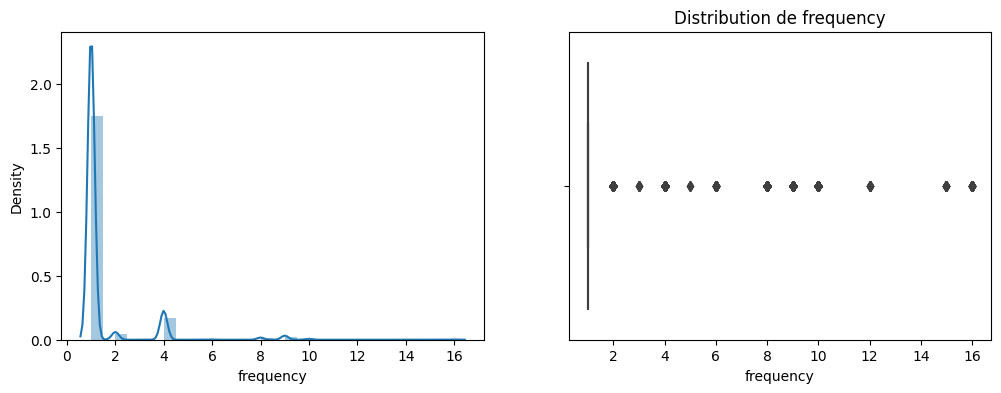

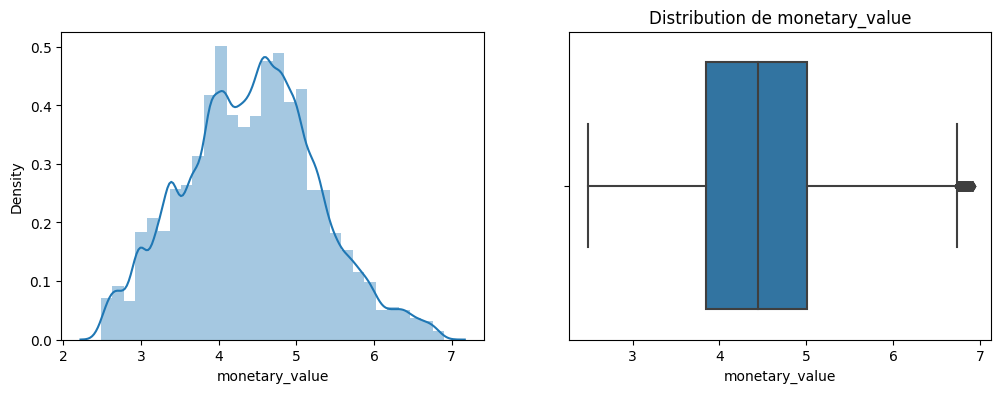

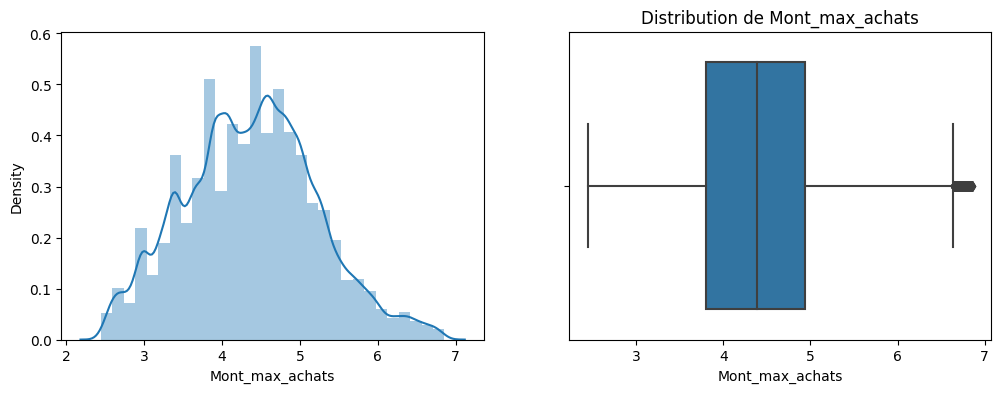

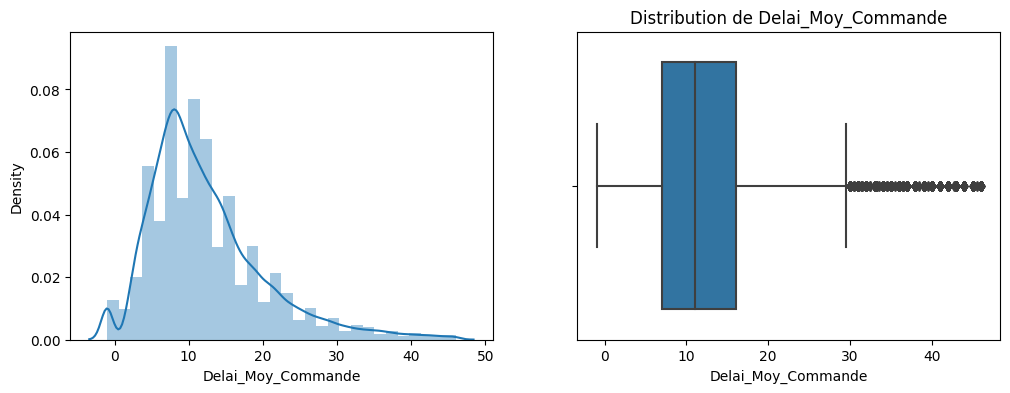

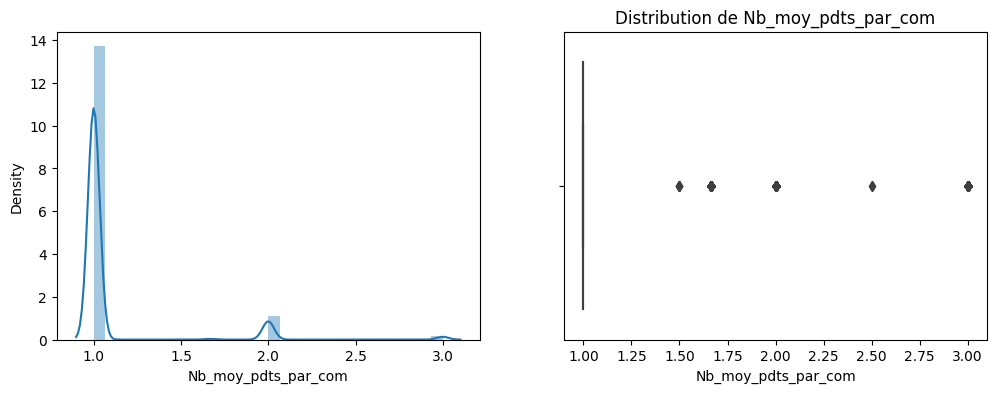

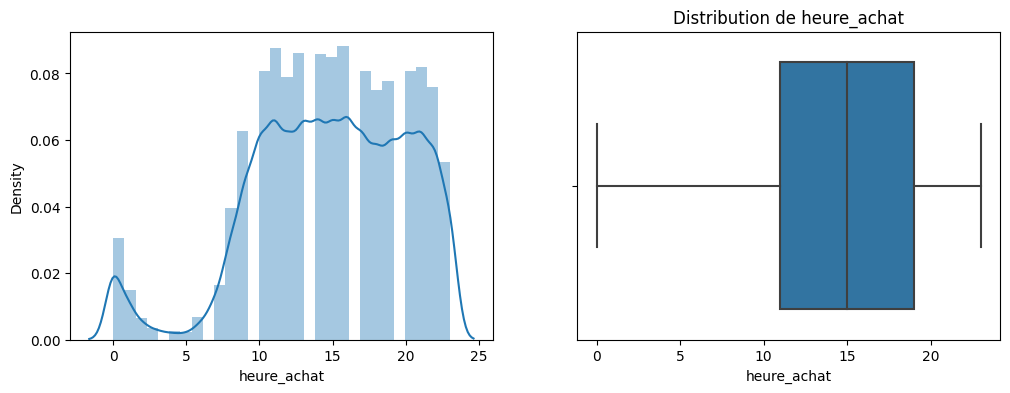

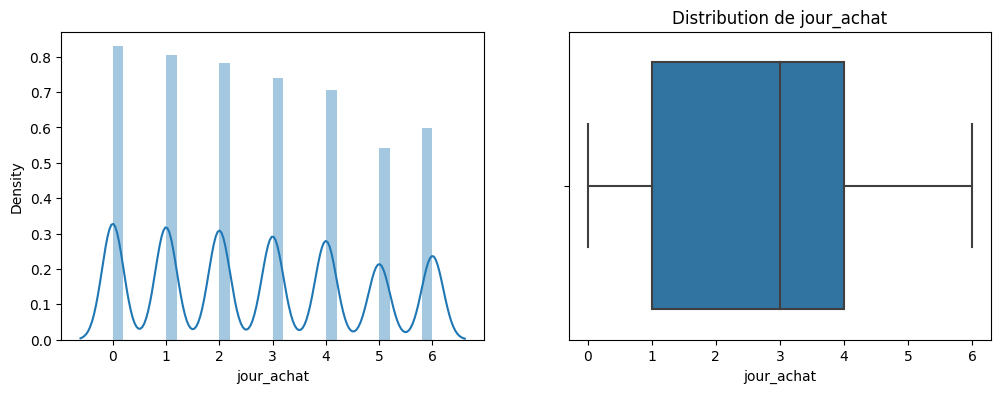

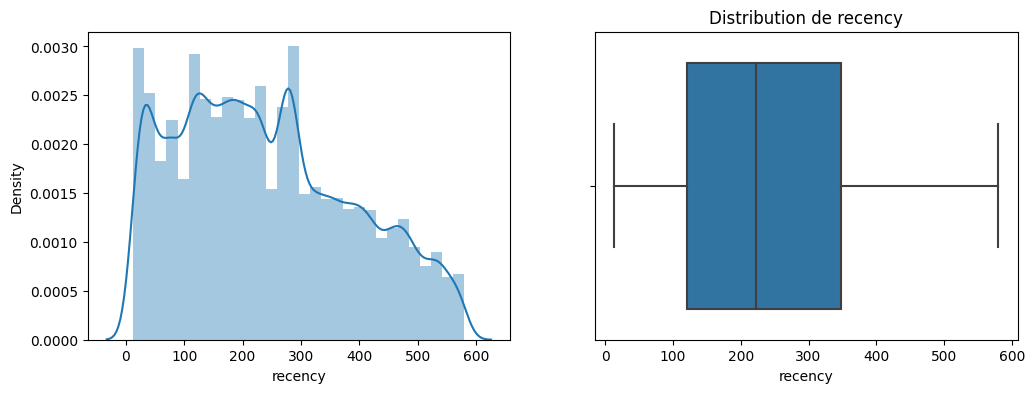

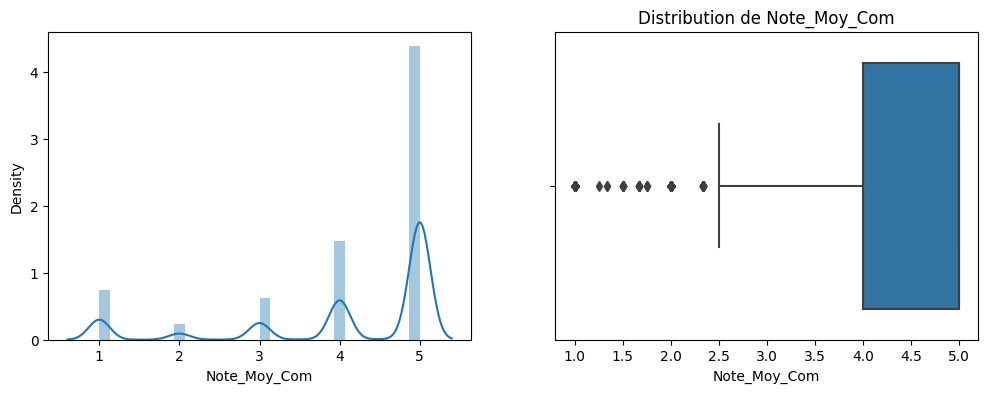

In [53]:
%matplotlib inline
for column in data_clients.select_dtypes(['int32', 'float64']).columns:
    f, axes = plt.subplots(1,2, figsize=(12,4))
    titre = 'Distribution de ' + str(column)
    plt.title(titre)
    sns.distplot(data_clients[column], bins=30, ax=axes[0])
    titre = 'Distribution de ' + str(column)
    plt.title(titre)
    sns.boxplot(data_clients[column], ax=axes[1])
    plt.show()

In [54]:
%matplotlib inline
for column in data_clients.select_dtypes(['int32', 'float64']).columns:
    if 'price' in column:
        f, axes = plt.subplots(1,2, figsize=(12,4))
        titre = 'Distribution de ' + str(column) +' sans valeur nulle'
        plt.title(titre)
        sns.distplot(data_clients[data_clients[column] != 0][column], bins=30, ax=axes[0])
        titre = 'Distribution de ' + str(column) +'sans valeur nulle'
        plt.title(titre)
        sns.boxplot(data_clients[data_clients[column] != 0][column], ax=axes[1])
        plt.show()

<Axes: title={'center': 'Les 10 états avec le plus de clients'}, ylabel='customer_state'>

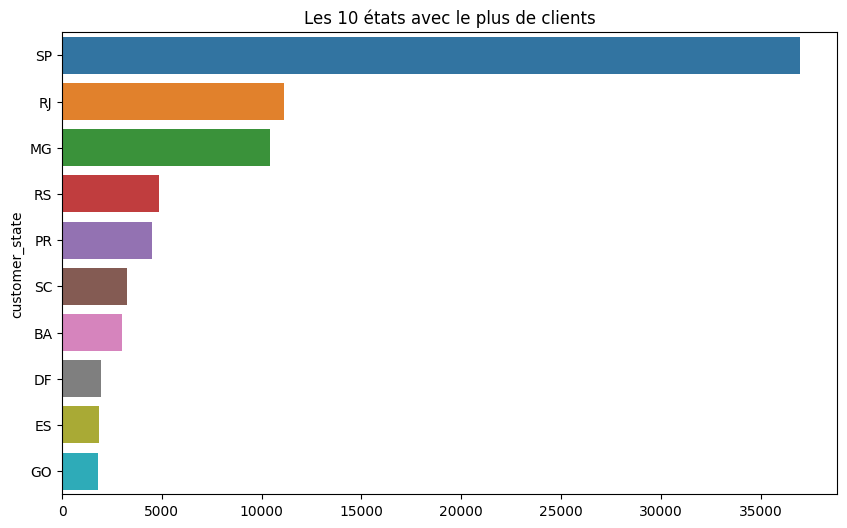

In [55]:
state = data_clients.groupby(['customer_state']).count().sort_values(
    by='customer_city', ascending=False)['customer_city'].head(10)
plt.figure(figsize=(10,6))
plt.title('Les 10 états avec le plus de clients')
sns.barplot(x = state.values,
           y = state.index)

In [56]:
data_clients

,Cat_la_plus_achetee,customer_zip_code_prefix,customer_city,customer_state,frequency,monetary_value,Mont_max_achats,Delai_Moy_Commande,Nb_moy_pdts_par_com,order_purchase_timestamp,heure_achat,jour_achat,recency,Note_Moy_Com,Moy_Paiment
customer_unique_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,home,7787,Other,SP,1.0,4.866765,4.866765,7.0,1.0,2018-05-10 10:56:27,10.0,3.0,115.0,5.0,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,6053,osasco,SP,1.0,2.939162,2.939162,4.0,1.0,2018-05-07 11:11:27,11.0,0.0,118.0,4.0,credit_card
0000f46a3911fa3c0805444483337064,office,88115,sao jose,SC,1.0,4.234107,4.234107,26.0,1.0,2017-03-10 21:05:03,21.0,4.0,541.0,3.0,credit_card
0000f6ccb0745a6a4b88665a16c9f078,electronics,66812,belem,PA,1.0,3.257712,3.257712,21.0,1.0,2017-10-12 20:29:41,20.0,3.0,325.0,4.0,credit_card
0004aac84e0df4da2b147fca70cf8255,electronics,18040,sorocaba,SP,1.0,5.192957,5.192957,14.0,1.0,2017-11-14 19:45:42,19.0,1.0,292.0,5.0,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,fashion,28909,Other,RJ,1.0,6.533789,6.533789,-1.0,1.0,2018-04-11 00:34:32,0.0,2.0,145.0,1.0,credit_card
fffea47cd6d3cc0a88bd621562a9d061,health_beauty,44054,feira de santana,BA,1.0,4.172694,4.172694,31.0,1.0,2017-12-10 20:07:56,20.0,6.0,266.0,4.0,credit_card
ffff371b4d645b6ecea244b27531430a,auto,78552,Other,MT,1.0,4.498698,4.498698,15.0,1.0,2017-02-07 15:49:16,15.0,1.0,572.0,5.0,credit_card


In [57]:
data_clients['Cat_la_plus_achetee'].unique()

array(['home', 'health_beauty', 'office', 'electronics', 'garden_pets',
       'sports_leisure', 'fashion', 'appliances', 'auto', 'food_drinks',
       'arts', 'other', 'construction'], dtype=object)

In [58]:
products['product_weight_g'].mean()

2276.4724877841513

<Axes: title={'center': 'Les 10 villes avec le plus de clients'}, ylabel='customer_city'>

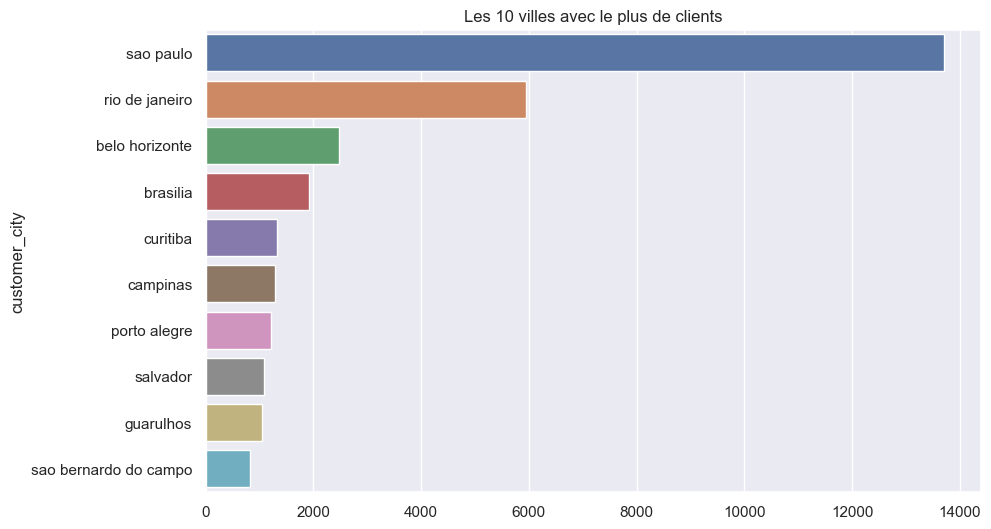

In [106]:
cities = data_clients[data_clients['customer_city'] !=  'Other'].groupby(['customer_city']).count()[
    'customer_state'].sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.title('Les 10 villes avec le plus de clients')
sns.barplot(x = cities.values,
           y = cities.index)

<Axes: title={'center': 'Répartition des catégories les plus achetées par les clients'}, ylabel='Cat_la_plus_achetee'>

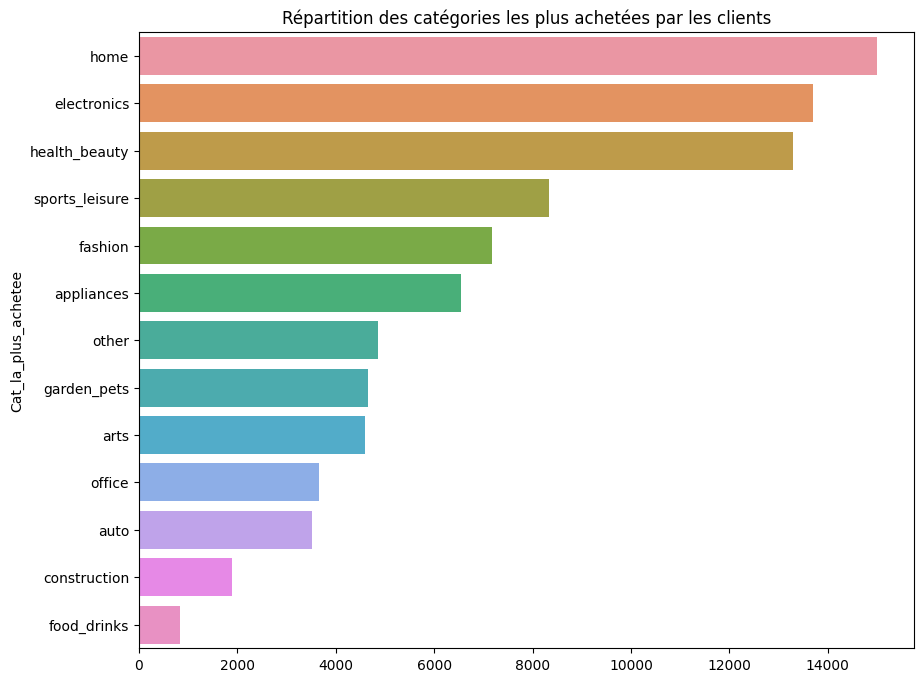

In [60]:
categories = data_clients.groupby(['Cat_la_plus_achetee']).count()[
    'customer_city'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Répartition des catégories les plus achetées par les clients')
sns.barplot(x = categories.values,
           y = categories.index)

<Axes: title={'center': 'Répartition des moyens de paiement plébiscités par les clients'}, ylabel='Moy_Paiment'>

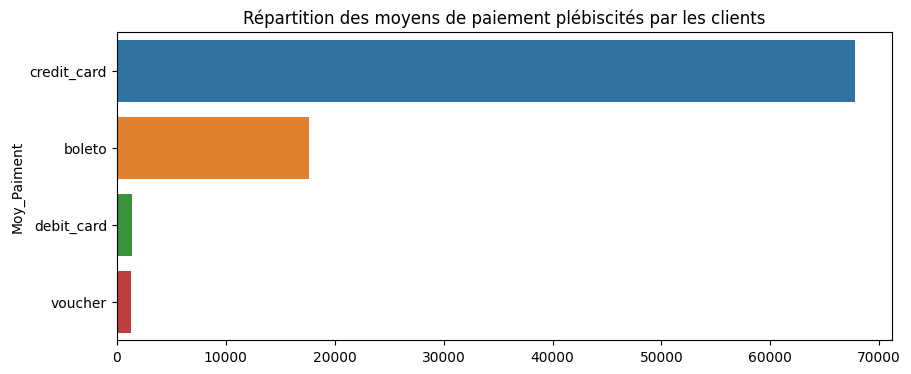

In [61]:
payment = data_clients.groupby(['Moy_Paiment']).count()[
    'customer_city'].sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.title('Répartition des moyens de paiement plébiscités par les clients')
sns.barplot(x = payment.values,
           y = payment.index)

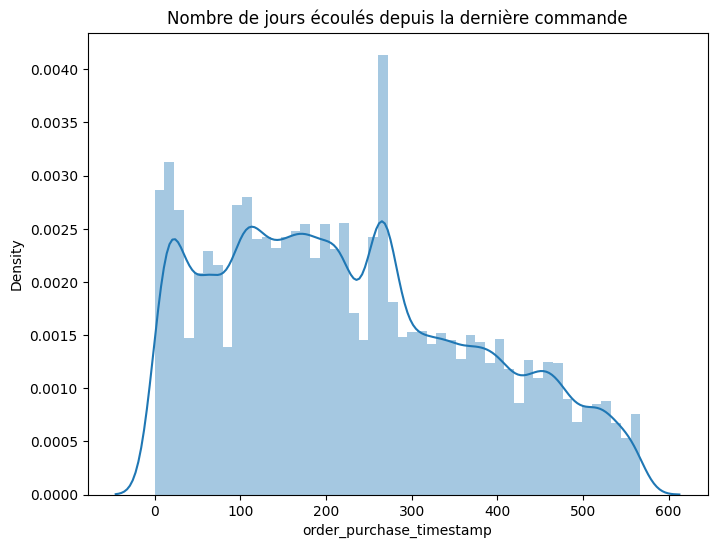

In [62]:
delai_achat = data_clients['order_purchase_timestamp'].max() - data_clients[
    'order_purchase_timestamp']
plt.figure(figsize=(8,6))
plt.title('Nombre de jours écoulés depuis la dernière commande')
sns.distplot(delai_achat.dt.days, bins=50)
plt.show()

**Conclusions sur l'analyse des distributions des variables:**
* très peu de clients ont fait plus d'un achat;
* les distributions des montants d'achat par catégorie sont d'allure exponentielle
* la variable price food drinks n'apporte pas d'information

### Corrélations

<Axes: >

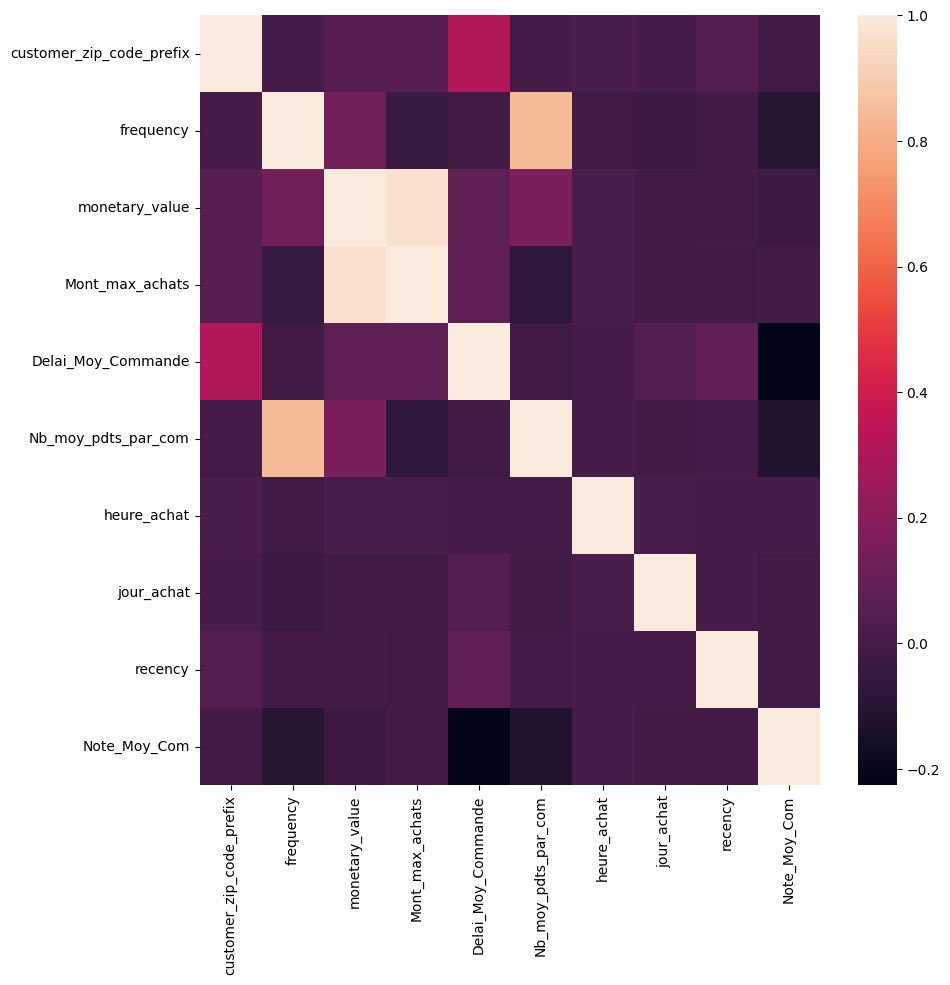

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(data_clients.corr())

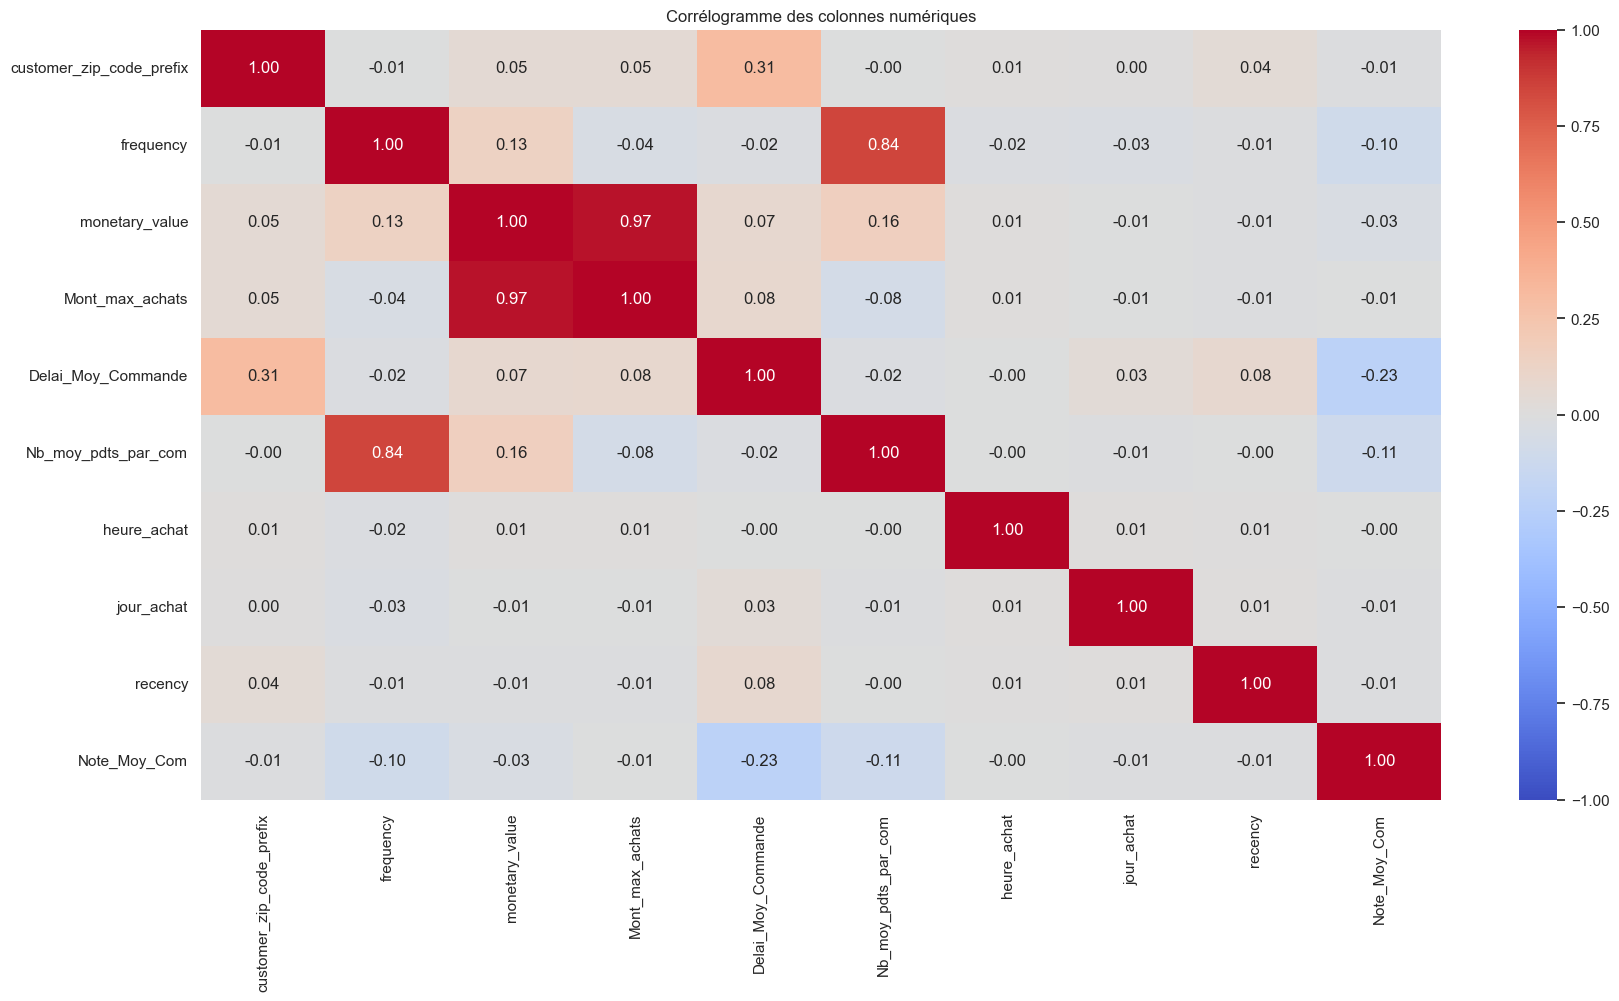

In [64]:
# Utilisation de la fonction avec votre DataFrame 'data_clients'
show_correlogram(data_clients)

Index(['frequency', 'monetary_value', 'Mont_max_achats', 'Delai_Moy_Commande',
       'Nb_moy_pdts_par_com', 'heure_achat', 'jour_achat', 'recency',
       'Note_Moy_Com'],
      dtype='object')


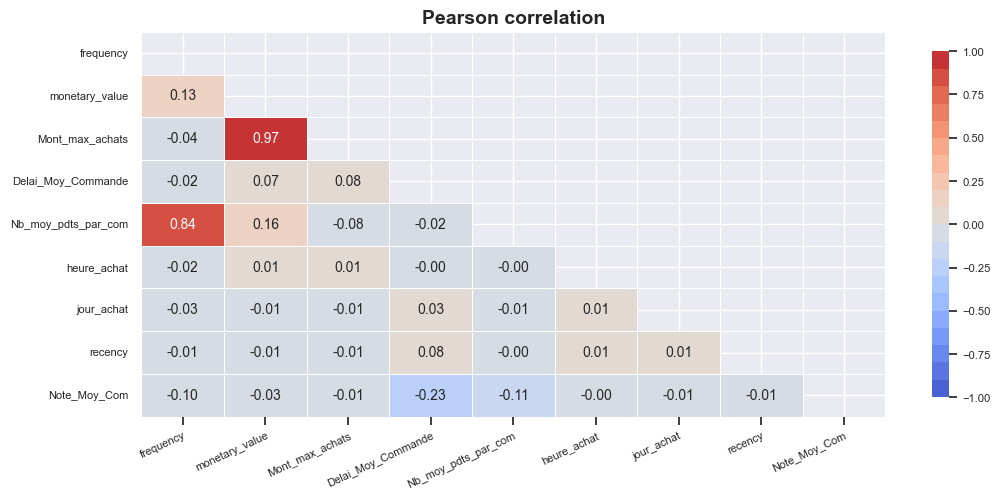

In [65]:
# Sélectionner les colonnes numériques
numeric_columns = data_clients.select_dtypes(['int32', 'float64', 'int8', 'float32']).columns
print(numeric_columns)
pears_corr = data_clients[numeric_columns].corr()
plot_heatmap(pears_corr, shape='tri', title="Pearson correlation", figsize=(12, 5))
plt.show()

On voit que certaines variables sont corrélées compte tenu du faible nombre de clients qui ont plusieurs transactions. C'est le cas de :
* nb de produits achetés avec nombre moyen de produits par commande
* montant total des achats avec montant moyen par commande

Egalement, la feature ('price', 'food_drinks') ne contient pas d'information

On va conserver une feature sur les 2 pour chaque corrélation

In [66]:
data_clients.drop(['Mont_max_achats','Nb_moy_pdts_par_com'], axis=1, inplace=True)

In [67]:
data_clients

,Cat_la_plus_achetee,customer_zip_code_prefix,customer_city,customer_state,frequency,monetary_value,Delai_Moy_Commande,order_purchase_timestamp,heure_achat,jour_achat,recency,Note_Moy_Com,Moy_Paiment
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,home,7787,Other,SP,1.0,4.866765,7.0,2018-05-10 10:56:27,10.0,3.0,115.0,5.0,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,6053,osasco,SP,1.0,2.939162,4.0,2018-05-07 11:11:27,11.0,0.0,118.0,4.0,credit_card
0000f46a3911fa3c0805444483337064,office,88115,sao jose,SC,1.0,4.234107,26.0,2017-03-10 21:05:03,21.0,4.0,541.0,3.0,credit_card
0000f6ccb0745a6a4b88665a16c9f078,electronics,66812,belem,PA,1.0,3.257712,21.0,2017-10-12 20:29:41,20.0,3.0,325.0,4.0,credit_card
0004aac84e0df4da2b147fca70cf8255,electronics,18040,sorocaba,SP,1.0,5.192957,14.0,2017-11-14 19:45:42,19.0,1.0,292.0,5.0,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,fashion,28909,Other,RJ,1.0,6.533789,-1.0,2018-04-11 00:34:32,0.0,2.0,145.0,1.0,credit_card
fffea47cd6d3cc0a88bd621562a9d061,health_beauty,44054,feira de santana,BA,1.0,4.172694,31.0,2017-12-10 20:07:56,20.0,6.0,266.0,4.0,credit_card
ffff371b4d645b6ecea244b27531430a,auto,78552,Other,MT,1.0,4.498698,15.0,2017-02-07 15:49:16,15.0,1.0,572.0,5.0,credit_card


# Export jeu de données 

In [68]:
data_clients.select_dtypes(['object']).nunique()

Cat_la_plus_achetee     13
customer_city          101
customer_state          27
Moy_Paiment              4
dtype: int64

In [69]:
data_clients.to_csv('data/data_cleaned.csv')

In [70]:
data_clients.sample(10)

,Cat_la_plus_achetee,customer_zip_code_prefix,customer_city,customer_state,frequency,monetary_value,Delai_Moy_Commande,order_purchase_timestamp,heure_achat,jour_achat,recency,Note_Moy_Com,Moy_Paiment
customer_unique_id,,,,,,,,,,,,,
92c54173e8993e733c038a5de394df7e,sports_leisure,18051,sorocaba,SP,1.0,3.218476,6.0,2018-06-14 11:13:34,11.0,3.0,80.0,5.0,credit_card
1b9f7574b77f7de613deec9ff5846a8a,other,38701,Other,MG,1.0,4.604170,15.0,2018-04-12 08:02:53,8.0,3.0,144.0,4.0,credit_card
e9999972797e433766f3bca71104b263,construction,6020,osasco,SP,1.0,5.247024,12.0,2018-06-04 22:12:02,22.0,0.0,90.0,2.0,boleto
2fdf0e3721cc331df29ae59f11786e87,office,88010,florianopolis,SC,1.0,5.634432,9.0,2018-05-14 19:03:59,19.0,0.0,111.0,5.0,credit_card
bcb1ba6dbec192171cb200325ebfd7d2,auto,89025,blumenau,SC,1.0,4.859890,8.0,2018-07-30 18:41:35,18.0,0.0,34.0,5.0,credit_card
6d6c7bcba410b2206fb3cb9c33c3707f,appliances,1226,sao paulo,SP,1.0,5.693732,8.0,2018-01-11 16:01:23,16.0,3.0,234.0,3.0,boleto
69768cfb4188e522fa75698ec28251dc,health_beauty,21350,rio de janeiro,RJ,1.0,5.010635,14.0,2017-12-29 07:43:35,7.0,4.0,248.0,5.0,boleto
5b2402c844755fa710ac2144f9db61c4,home,30130,belo horizonte,MG,1.0,4.875197,12.0,2018-07-12 10:59:24,10.0,3.0,52.0,1.0,credit_card
9d0f27ebe07860991987111d254339da,electronics,77900,Other,TO,1.0,3.090588,18.0,2017-08-26 15:00:54,15.0,5.0,372.0,5.0,credit_card


In [71]:
data_clients.describe()

,customer_zip_code_prefix,frequency,monetary_value,Delai_Moy_Commande,heure_achat,jour_achat,recency,Note_Moy_Com
count,88018.000000,88018.000000,88018.000000,88018.000000,88018.000000,88018.000000,88018.000000,88018.000000
mean,35232.981947,1.448374,4.425537,12.333883,14.769820,2.741110,240.716490,4.139524
std,29859.674903,1.427240,0.853831,7.829078,5.302995,1.969223,148.122622,1.293813
min,1003.000000,1.000000,2.484907,-1.000000,0.000000,0.000000,13.000000,1.000000
25%,11365.000000,1.000000,3.848018,7.000000,11.000000,1.000000,120.000000,4.000000
50%,24451.000000,1.000000,4.442651,11.000000,15.000000,3.000000,223.000000,5.000000
75%,59067.000000,1.000000,5.003946,16.000000,19.000000,4.000000,348.000000,5.000000
max,99990.000000,16.000000,6.905753,46.000000,23.000000,6.000000,580.000000,5.000000


In [72]:
geolocalisation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [73]:
data_clients

,Cat_la_plus_achetee,customer_zip_code_prefix,customer_city,customer_state,frequency,monetary_value,Delai_Moy_Commande,order_purchase_timestamp,heure_achat,jour_achat,recency,Note_Moy_Com,Moy_Paiment
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,home,7787,Other,SP,1.0,4.866765,7.0,2018-05-10 10:56:27,10.0,3.0,115.0,5.0,credit_card
0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,6053,osasco,SP,1.0,2.939162,4.0,2018-05-07 11:11:27,11.0,0.0,118.0,4.0,credit_card
0000f46a3911fa3c0805444483337064,office,88115,sao jose,SC,1.0,4.234107,26.0,2017-03-10 21:05:03,21.0,4.0,541.0,3.0,credit_card
0000f6ccb0745a6a4b88665a16c9f078,electronics,66812,belem,PA,1.0,3.257712,21.0,2017-10-12 20:29:41,20.0,3.0,325.0,4.0,credit_card
0004aac84e0df4da2b147fca70cf8255,electronics,18040,sorocaba,SP,1.0,5.192957,14.0,2017-11-14 19:45:42,19.0,1.0,292.0,5.0,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,fashion,28909,Other,RJ,1.0,6.533789,-1.0,2018-04-11 00:34:32,0.0,2.0,145.0,1.0,credit_card
fffea47cd6d3cc0a88bd621562a9d061,health_beauty,44054,feira de santana,BA,1.0,4.172694,31.0,2017-12-10 20:07:56,20.0,6.0,266.0,4.0,credit_card
ffff371b4d645b6ecea244b27531430a,auto,78552,Other,MT,1.0,4.498698,15.0,2017-02-07 15:49:16,15.0,1.0,572.0,5.0,credit_card


In [74]:
data_clients.columns

Index(['Cat_la_plus_achetee', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'frequency', 'monetary_value', 'Delai_Moy_Commande',
       'order_purchase_timestamp', 'heure_achat', 'jour_achat', 'recency',
       'Note_Moy_Com', 'Moy_Paiment'],
      dtype='object')

In [75]:
import pandas as pd

# Afficher l'index actuel du DataFrame data_clients
print(data_clients.index)
#

Index(['0000366f3b9a7992bf8c76cfdf3221e2', '0000b849f77a49e4a4ce2b2a4ca5be3f',
       '0000f46a3911fa3c0805444483337064', '0000f6ccb0745a6a4b88665a16c9f078',
       '0004aac84e0df4da2b147fca70cf8255', '0004bd2a26a76fe21f786e4fbd80607f',
       '00050ab1314c0e55a6ca13cf7181fecf', '00053a61a98854899e70ed204dd4bafe',
       '0005e1862207bf6ccc02e4228effd9a0', '0006fdc98a402fceb4eb0ee528f6a8d4',
       ...
       'fff7219c86179ca6441b8f37823ba3d3', 'fff96bc586f78b1f070da28c4977e810',
       'fffa431dd3fcdefea4b1777d114144f2', 'fffb09418989a0dbff854a28163e47c6',
       'fffbf87b7a1a6fa8b03f081c5f51a201', 'fffcc512b7dfecaffd80f13614af1d16',
       'fffea47cd6d3cc0a88bd621562a9d061', 'ffff371b4d645b6ecea244b27531430a',
       'ffff5962728ec6157033ef9805bacc48', 'ffffd2657e2aad2907e67c3e9daecbeb'],
      dtype='object', name='customer_unique_id', length=88018)


In [77]:
# Charger les données
customers = pd.read_csv('data/olist_customers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
translation = pd.read_csv('data/product_category_name_translation.csv')

## Analyse RFM

In [78]:
import datetime as dt

# rfm_df = ddb.query(
#     """
#     SELECT
#         customer_unique_id, 
#         MAX(order_purchase_timestamp) as last_order,
#         COUNT(DISTINCT o.order_id) as frequency,
#         SUM(payment_value) as monetary_value
#     FROM customers as c
#     JOIN orders as o on c.customer_id = o.customer_id
#     JOIN order_payments as p on o.order_id = p.order_id
#     WHERE order_purchase_timestamp <= '2018-08-31 23:59:59'
#     AND   order_purchase_timestamp >= '2017-09-01 00:00:00'
#     GROUP BY customer_unique_id
#     HAVING SUM(payment_value) <= 5500
#     """
# ).to_df()

rfm_df = ddb.query(
    """
    SELECT
        c.customer_unique_id, 
        MAX(o.order_purchase_timestamp) as last_order,
        COUNT(DISTINCT o.order_id) as frequency,
        SUM(p.payment_value) as monetary_value,
        AVG(r.review_score) as review_score,
        CASE
            WHEN AVG(r.review_score) >= 4.0 THEN 'Satisfied'
            ELSE 'Not Satisfied'
        END as satisfaction_status
    FROM customers as c
    JOIN orders as o on c.customer_id = o.customer_id
    JOIN order_payments as p on o.order_id = p.order_id
    LEFT JOIN order_reviews as r on o.order_id = r.order_id
    WHERE o.order_purchase_timestamp <= '2018-08-31 23:59:59'
    AND   o.order_purchase_timestamp >= '2017-09-01 00:00:00'
    GROUP BY c.customer_unique_id
    HAVING SUM(p.payment_value) <= 5500
    """
).to_df()

rfm_df["recency"] = rfm_df[["last_order"]].applymap(lambda o: (dt.datetime.strptime('2018-08-31 23:59:59', '%Y-%m-%d %H:%M:%S') - dt.datetime.strptime(o, '%Y-%m-%d %H:%M:%S')).days)
rfm_df["mean_monetary_value"] = rfm_df.monetary_value / rfm_df.frequency

# Calculer la date de la dernière commande (récence)
# current_date = df['order_purchase_timestamp'].max()
# df['recency'] = (current_date - df['order_purchase_timestamp']).dt.days

rfm_df.head()


,customer_unique_id,last_order,frequency,monetary_value,review_score,satisfaction_status,recency,mean_monetary_value
0,8bca2409e2cb4430ac988a031dcf7fc3,2017-10-16 10:50:53,1,65.71,5.0,Satisfied,319,65.71
1,62f40b4d76e73eadb555e3151e46fb24,2018-04-08 11:56:10,1,199.04,1.0,Not Satisfied,145,199.04
2,edf9297cc47d6ccecdca1789c7eed363,2017-12-18 14:29:33,1,311.79,5.0,Satisfied,256,311.79
3,c10a7d9e6cd783c08d361319a5b7f396,2017-12-04 19:22:50,1,71.04,4.0,Satisfied,270,71.04
4,dfd745964828b2a884c373b7d48253de,2017-10-09 22:59:50,1,68.02,5.0,Satisfied,326,68.02


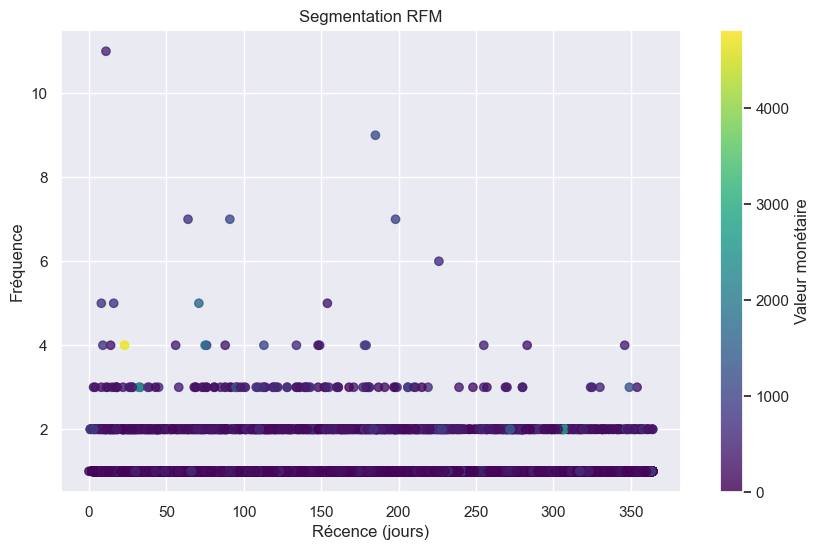

In [79]:
import matplotlib.pyplot as plt

# Création d'un diagramme en nuage de points (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_df['recency'], rfm_df['frequency'], c=rfm_df['monetary_value'], cmap='viridis', alpha=0.8)
plt.colorbar(label='Valeur monétaire')
plt.xlabel('Récence (jours)')
plt.ylabel('Fréquence')
plt.title('Segmentation RFM')
plt.grid(True)
plt.show()


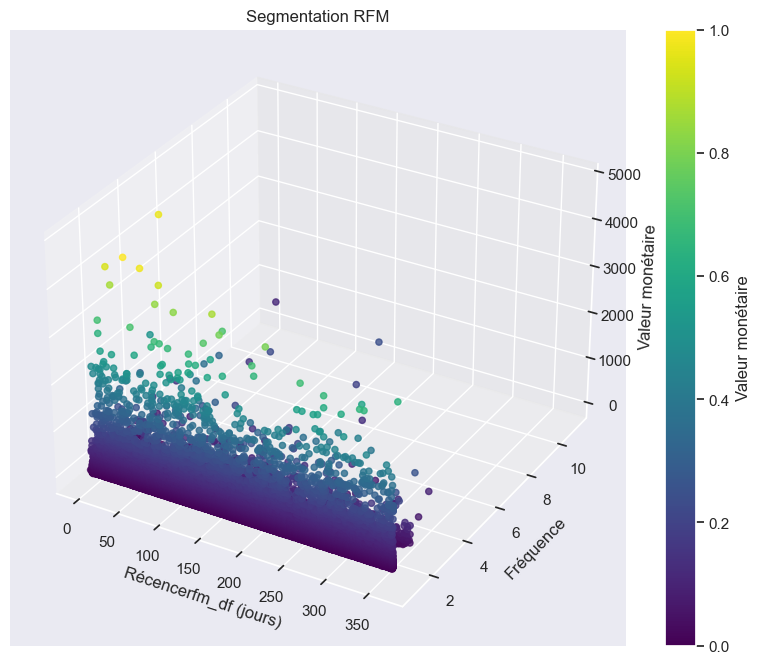

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# # Assigner les scores RFM à chaque client
# df['R'] = df['recency'].apply(assign_rfm_score, args=(recency_quartiles,))
# df['F'] = df['frequency'].apply(assign_rfm_score, args=(frequency_quartiles,))
# df['M'] = df['total_spent'].apply(assign_rfm_score, args=(monetary_quartiles,))
# Création d'un graphique en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ajout des points sur le graphique en 3D
ax.scatter(rfm_df['recency'], rfm_df['frequency'], rfm_df['monetary_value'], c=rfm_df['monetary_value'], cmap='viridis', alpha=0.8)

# Configuration des axes
ax.set_xlabel('Récencerfm_df (jours)')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Valeur monétaire')
ax.set_title('Segmentation RFM')

# Ajout de la barre de couleur pour représenter la valeur monétaire
cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'), ax=ax)
cbar.set_label('Valeur monétaire')

plt.show()


## Carte vendeur

In [ ]:
# Créer une connexion à la base de données DuckDB
con = ddb.connect()

# Requête SQL pour récupérer les localisations des vendeurs sans valeurs nulles ou NaN
query = """
    SELECT
        c.seller_id AS id,
        c.seller_city AS city,
        c.seller_state AS state,
        AVG(g.geolocation_lat) AS lat,
        AVG(g.geolocation_lng) AS lng
    FROM sellers AS c
    LEFT JOIN geolocation AS g ON c.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        and c.seller_city = g.geolocation_city
    WHERE g.geolocation_lat IS NOT NULL AND g.geolocation_lng IS NOT NULL
    GROUP BY c.seller_id, c.seller_city, c.seller_state
"""

# Exécuter la requête
locations_df = con.execute(query).fetchdf()
locations_df.sample(5)

In [ ]:
# Création de la carte
m = folium.Map(location=[locations_df['lat'].mean(), locations_df['lng'].mean()], zoom_start=4)

# Ajout des clusters de marqueurs
marker_cluster = MarkerCluster().add_to(m)
for idx, row in locations_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=row['city'] + ', ' + row['state']
    ).add_to(marker_cluster)

# Afficher le menu déroulant
folium.LayerControl().add_to(m)

# Afficher la carte interactive
m

## Carte Client

In [ ]:
# Créer une connexion à la base de données DuckDB
con = ddb.connect()

# # Requête SQL pour récupérer les localisations uniques des clients sans valeurs nulles ou NaN
# query = """
#     SELECT DISTINCT
#         c.customer_id AS id,
#         c.customer_city AS city,
#         c.customer_state AS state,
#         g.geolocation_lat AS lat,
#         g.geolocation_lng AS lng
#     FROM customers AS c
#     LEFT JOIN geolocation AS g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
#     WHERE g.geolocation_lat IS NOT NULL AND g.geolocation_lng IS NOT NULL
# """
# Requête SQL pour récupérer les localisations uniques des clients sans valeurs nulles ou NaN
query = """
    SELECT
        c.customer_id AS id,
        c.customer_city AS city,
        c.customer_state AS state,
        AVG(g.geolocation_lat) AS lat,
        AVG(g.geolocation_lng) AS lng
    FROM customers AS c
    LEFT JOIN geolocation AS g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
        and c.customer_city = g.geolocation_city
    WHERE g.geolocation_lat IS NOT NULL AND g.geolocation_lng IS NOT NULL
    GROUP BY c.customer_id, c.customer_city, c.customer_state
"""

# Exécuter la requête
locations_df = con.execute(query).fetchdf()
locations_df.sample(5)


In [ ]:
# Création de la carte
m = folium.Map(location=[locations_df['lat'].mean(), locations_df['lng'].mean()], zoom_start=4)

# Ajout des clusters de marqueurs
marker_cluster = MarkerCluster().add_to(m)
for idx, row in locations_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=row['city'] + ', ' + row['state']
    ).add_to(marker_cluster)

# Afficher le menu déroulant
folium.LayerControl().add_to(m)

# Afficher la carte interactive
m

### Distribution des commandes par mois

In [ ]:
orders["period"] = orders[["order_purchase_timestamp"]].applymap(lambda o: str(dt.datetime.strptime(
    o, '%Y-%m-%d %H:%M:%S').year * 100 + dt.datetime.strptime(o, '%Y-%m-%d %H:%M:%S').month))
sorted_orders = orders.sort_values(by=["period"])

fig = plt.figure(figsize=[24, 8])
sns.displot(sorted_orders["period"])
plt.xticks(rotation=90)
plt.show()


# Utilisation de Duckdb pour faire des requetes SQL

In [26]:
# Enregistrer le DataFrame dans un fichier CSV
# rfm_df.to_csv('data/data_cleaned_rfm.csv', index=False)

In [84]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

customers.attrs['name'] = "customers"
geolocation.attrs['name'] = "geolocation"
order_items.attrs['name'] = "order_items"
order_payments.attrs['name'] = "order_payments"
order_reviews.attrs['name'] = "order_reviews"
orders.attrs['name'] = "orders"
products.attrs['name'] = "products"
sellers.attrs['name'] = "sellers"
product_category_name_translation.attrs['name'] = "product_category_name_translation"


In [85]:
order_items = remove_outliers(order_items, ["price", "freight_value"])

In [86]:
order_payments = remove_outliers(order_payments, ["payment_value"])

In [87]:
order_reviews["review_comment_message"] = order_reviews["review_comment_message"].fillna('')
order_reviews["review_comment_title"] = order_reviews["review_comment_title"].fillna('')

In [88]:
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"])
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_carrier_date"] = pd.to_datetime(
    orders["order_delivered_carrier_date"])
orders["order_delivered_customer_date"] = pd.to_datetime(
    orders["order_delivered_customer_date"])

orders["order_approved_in_seconds"] = orders["order_approved_at"] - \
    orders["order_purchase_timestamp"]
orders["order_delivered_carrier_in_seconds"] = orders["order_delivered_carrier_date"] - \
    orders["order_purchase_timestamp"]
orders["order_delivered_customer_in_seconds"] = orders["order_delivered_customer_date"] - \
    orders["order_purchase_timestamp"]

orders["order_approved_at"] = orders["order_approved_at"].fillna(
    orders["order_purchase_timestamp"] + orders["order_approved_in_seconds"].median())
orders["order_delivered_carrier_date"] = orders["order_delivered_carrier_date"].fillna(
    orders["order_purchase_timestamp"] + orders["order_delivered_carrier_in_seconds"].median())
orders["order_delivered_customer_date"] = orders["order_delivered_customer_date"].fillna(
    orders["order_purchase_timestamp"] + orders["order_delivered_customer_in_seconds"].median())

orders = orders.drop([
    "order_approved_in_seconds",
    "order_delivered_carrier_in_seconds",
    "order_delivered_customer_in_seconds"
], axis=1)


##### Products

Certains produits n'ont pas de dimension.

Il y en a assez peu, on peut les supprimer de la liste.

Par ailleurs, il manque certaine description, que l'on peut assigner à des valeurs par défaut

In [89]:
products = products.dropna(subset=['product_weight_g', 'product_length_cm', 'product_width_cm', 'product_length_cm'])

products["product_category_name"] = products["product_category_name"].fillna("No Category")
products["product_name_lenght"] = products["product_name_lenght"].fillna(0)
products["product_description_lenght"] = products["product_description_lenght"].fillna(0)
products["product_photos_qty"] = products["product_photos_qty"].fillna(0)


### Customer ID et Customer unique ID

In [90]:
customer_ids = customers['customer_id'].unique().shape[0]
customer_unique_ids = customers['customer_unique_id'].unique().shape[0]
print("customer_ids : " + str(customer_ids))
print("customer_unique_ids : " + str(customer_unique_ids))
print('Ecart : ', np.round(100 * (customer_ids - customer_unique_ids) / customer_ids, 2), '%')

customer_ids : 99441
customer_unique_ids : 96096
Ecart :  3.36 %


La variable `customer_unique_id` représente l'idenfiant du client. 

La variable `customer_id` représente le code du client attribué à la commande. 

On retrouve ici l'écart de 3%, correspondant aux clients ayant passé plusieurs commandes. 

La table `customers` n'est pas la liste unique des clients mais la "relation" entre clients et commandes. 

Pour cette raison, on retrouve les clients ayant passé plusieurs commandes plusieurs fois dans le jeu de données. 


### Répartition des commandes dans le temps

In [91]:
print("Première commande du jeu de données : " + str(np.min(orders.order_purchase_timestamp)))
print("Dernière commande du jeu de données : " + str(np.max(orders.order_purchase_timestamp)))

Première commande du jeu de données : 2016-09-04 21:15:19
Dernière commande du jeu de données : 2018-10-17 17:30:18


<Figure size 2400x800 with 0 Axes>

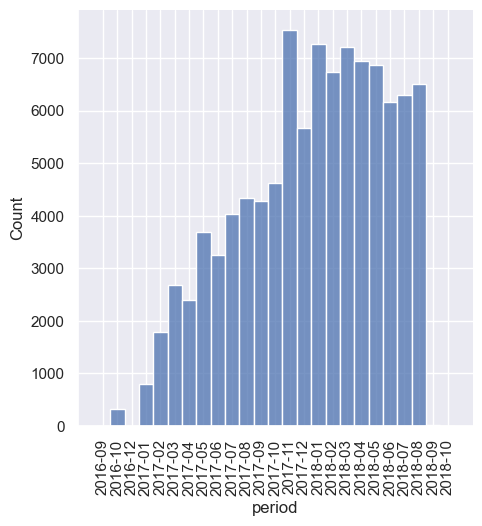

In [92]:
orders["period"] = orders[["order_purchase_timestamp"]].applymap(lambda o: str(o.year) + '-' + str(o.month).rjust(2, "0"))
sorted_orders = orders.sort_values(by=["period"])

fig = plt.figure(figsize=[24, 8])
sns.displot(sorted_orders["period"])
plt.xticks(rotation=90)
plt.show()

In [93]:
import datetime as dt
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [94]:
from dateutil.relativedelta import relativedelta
import datetime

# Initialiser les variables
start_train_date = dt.date(2017, 1, 1)
end_train_date = dt.date(2017, 12, 31)
end_eval_date = dt.date(2018, 8, 31)
n_months = 1
update_periods = []  # Liste pour stocker les périodes de mise à jour

while end_train_date <= end_eval_date:
    start_train_date = add_months(start_train_date, n_months)
    end_train_date = add_months(end_train_date, n_months)

    print(end_train_date)

    update_periods.append(end_train_date)



2018-01-31
2018-02-28
2018-03-28
2018-04-28
2018-05-28
2018-06-28
2018-07-28
2018-08-28
2018-09-28


# Nouvel ARI

### Fonction RFM

In [95]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["period"] = orders[["order_purchase_timestamp"]].applymap(lambda o: str(o.year * 100 + o.month))

In [96]:
import duckdb as ddb
from datetime import datetime
    
def getRfmNewData(start_period, end_period):
#     # Obtenir la date et l'heure actuelles
#     current_datetime = datetime.now()

#     # Convertir la date en une chaîne au format approprié pour DuckDB
#     current_datetime_str = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
    rfm_prod_val = ddb.query(
        """
        SELECT o.customer_id, p.product_category_name, AVG(i.price) as price
        FROM orders as o
        JOIN order_payments as r on o.order_id = r.order_id
        JOIN order_items as i on o.order_id = i.order_id
        JOIN products as p on i.product_id = p.product_id
        WHERE o.period between '""" + start_period +  """' AND '""" + end_period + """'
        GROUP BY o.customer_id, p.product_category_name
        """
    )

    rfm_category_count = ddb.query(
        """
        select c.customer_unique_id, p.product_category_name, count(p.product_id) as products
        from customers as c
        join orders as o on c.customer_id = o.customer_id
        join order_items as i on o.order_id = i.order_id
        join products as p on i.product_id = p.product_id
        where o.period between '""" + start_period +  """' and '""" + end_period + """'
        group by c.customer_unique_id, p.product_category_name
        """
    )

    rfm_prod_cat = ddb.query(
        """
        select x.customer_unique_id, max(x.product_category_name) as product_category_name
        from rfm_category_count as x
        join (
            select customer_unique_id, max(products) as max_products
            from rfm_category_count
            group by customer_unique_id
        ) as y
            on x.customer_unique_id = y.customer_unique_id
            and max_products = products
        group by x.customer_unique_id
        """
    )

    rfm_payment_count = ddb.query(
        """
        select c.customer_unique_id, p.payment_type, count(payment_value) as payments
        from customers as c
        join orders as o on c.customer_id = o.customer_id
        join order_payments as p on o.order_id = p.order_id
        where o.period between '""" + start_period +  """' and '""" + end_period + """'
        group by c.customer_unique_id, p.payment_type
        """
    )

    rfm_fav_pay = ddb.query(
        """
        select x.customer_unique_id, max(x.payment_type) as payment_type
        from rfm_payment_count as x
        join (
            select customer_unique_id, max(payments) as max_payments
            from rfm_payment_count
            group by customer_unique_id
        ) as y
            on x.customer_unique_id = y.customer_unique_id
            and  x.payments = max_payments
        group by x.customer_unique_id
        """
    )

    rfm_customers = ddb.query(
        """
        select distinct customer_unique_id
        from customers as c
        join orders as o on c.customer_id = o.customer_id
        where period <= '201712'
        """
    )

#     rfm_feats = ddb.query(
#         """
#         select
#             c.customer_unique_id,
#             o.period,
#             sum(pay.payment_value) as total_dep_by_customer,
#             count(i.product_id) as nb_products_buy,
#             sum(p.product_length_cm * p.product_width_cm * p.product_length_cm) as volume_product_cm3,
#             cat.product_category_name as fav_categ,
#             avg(coalesce(r.review_score, 3)) as eval_mean_per_customer,
#             sum(case coalesce(r.review_comment_message, '')  when '' then 0 else 1 end) as nb_of_comment,
#             f.payment_type as fav_payment_type
#             -- distance_customer_seller
#         from customers as c
#         -- join rfm_customers as rc on c.customer_unique_id = rc.customer_unique_id
#         join orders as o on c.customer_id = o.customer_id
#         join order_items as i on o.order_id = i.order_id
#         join order_payments as pay on o.order_id = pay.order_id
#         join products as p on i.product_id = p.product_id
#         join rfm_prod_cat as cat on c.customer_unique_id = cat.customer_unique_id
#         join rfm_fav_pay as f on c.customer_unique_id = f.customer_unique_id
#         left join order_reviews as r on o.order_id = r.order_id
#         where o.period between '""" + start_period +  """' and '""" + end_period + """'
#         group by
#             c.customer_unique_id,
#             cat.product_category_name,
#             o.period,
#             f.payment_type
#     """).to_df()


# Exécute une requête sur une base de données (ddb) pour extraire des données relatives aux comportements d'achat des clients
    rfm_feats = ddb.query(
        """
        SELECT
            -- Sélection des colonnes à extraire
            c.customer_unique_id, -- Identifiant unique du client
            o.period, -- Période des commandes
            MAX(o.order_purchase_timestamp) as last_order,
            count(o.order_id) as frequency,  -- Calcul de la fréquence
            SUM(pay.payment_value) / COUNT(o.order_id) as monetary_value,  -- Calcul du prix moyen du panier
            SUM(pay.payment_value) AS total_dep_by_customer, -- Somme des paiements effectués par le client
            COUNT(i.product_id) AS nb_products_buy, -- Nombre de produits achetés par le client
            SUM(p.product_length_cm * p.product_width_cm * p.product_length_cm) AS volume_product_cm3, -- Volume total des produits achetés par le client
            cat.product_category_name AS fav_categ, -- Catégorie de produit préférée du client
            AVG(COALESCE(r.review_score, 3)) AS eval_mean_per_customer, -- Note moyenne attribuée par le client (3 est la note par défaut si aucune note n'est disponible)
            SUM(CASE COALESCE(r.review_comment_message, '') WHEN '' THEN 0 ELSE 1 END) AS nb_of_comment, -- Nombre de commentaires laissés par le client
            f.payment_type AS fav_payment_type, -- Type de paiement préféré du client
             CASE
                 WHEN avg(coalesce(r.review_score, 3)) >= 4.0 THEN 'Satisfait'
                 ELSE 'Non Satisfait'
             END as satisfaction_client  -- Calcul et ajout de la satisfaction client
        FROM
            customers AS c
        -- Rejoint les tables suivantes pour obtenir les données nécessaires
        JOIN orders AS o ON c.customer_id = o.customer_id
        JOIN order_items AS i ON o.order_id = i.order_id
        JOIN order_payments AS pay ON o.order_id = pay.order_id
        JOIN products AS p ON i.product_id = p.product_id
        JOIN rfm_prod_cat AS cat ON c.customer_unique_id = cat.customer_unique_id
        JOIN rfm_fav_pay AS f ON c.customer_unique_id = f.customer_unique_id
        LEFT JOIN order_reviews AS r ON o.order_id = r.order_id -- Jointure gauche pour inclure les évaluations même si elles sont manquantes
        WHERE
            o.period BETWEEN '""" + start_period +  """' AND '""" + end_period + """' -- Filtre par période
        GROUP BY
            -- Regroupe les résultats en fonction des colonnes spécifiées
            c.customer_unique_id,
            cat.product_category_name,
            o.period,
            f.payment_type
    """  
    ).to_df()  # Stocke les résultats dans un DataFrame appelé rfm_feats pour une utilisation ultérieure

    
#     rfm_feats["recency"] = rfm_feats[["recency"]].applymap(lambda o: o.days)

    # Supposez que "last_order" est une colonne de type Timestamp dans votre DataFrame rfm_feats
    rfm_feats["recency"] = (pd.Timestamp('2018-08-31 23:59:59') - rfm_feats["last_order"]).dt.days

#     rfm_feats["recency"] = rfm_feats[["last_order"]].applymap(lambda o: (dt.datetime.strptime('2018-08-31 23:59:59', '%Y-%m-%d %H:%M:%S') - dt.datetime.strptime(o, '%Y-%m-%d %H:%M:%S')).days)
# rfm_df["mean_monetary_value"] = rfm_df.monetary_value / rfm_df.frequency

    return rfm_feats

Bien sûr, voici le texte mis à jour avec l'ajout de l'interêt **Intérêt** pour chaque caractéristique manquante :

1. **Identifiant Unique du Client (`customer_unique_id`) :**
   - C'est l'identifiant unique de chaque client, ce qui permet de suivre individuellement chaque client.
   - **Intérêt** : Permet d'identifier de manière unique chaque client, ce qui est essentiel pour personnaliser les communications marketing et suivre le comportement d'achat de chaque client au fil du temps.

2. **Période des Commandes (`period`) :**
   - Indique la période pendant laquelle les commandes ont été passées. Cela peut être utile pour suivre les tendances saisonnières ou temporelles.
   - **Intérêt** : Indique quand les commandes ont été passées. Cela permet au service marketing de suivre les tendances saisonnières, de planifier des campagnes promotionnelles en fonction des périodes d'achat et d'analyser comment le comportement des clients évolue au fil du temps.

3. **Dernière Commande (`last_order`) :**
   - Cette colonne contient la date de la dernière commande du client. Cela peut être utilisé pour identifier les clients inactifs ou pour des offres de fidélisation spécifiques aux clients récents.
   - **Intérêt** : Permet de cibler les clients inactifs pour des campagnes de fidélisation ou d'offrir des incitations aux clients récents pour favoriser la fidélisation.

4. **Fréquence (`frequency`) :**
   - La fréquence des commandes représente le nombre de commandes effectuées par le client. C'est une mesure de la fidélité du client.
   - **Intérêt** : Donne une idée claire de la valeur monétaire que chaque client apporte à l'entreprise. Cela permet de segmenter les clients en fonction de leur valeur et de cibler les offres promotionnelles en conséquence.

5. **Prix Moyen du Panier (`monetary_value`) :**
   - Cette valeur représente le montant moyen dépensé par le client par commande. Utile pour identifier les segments de clients à fort pouvoir d'achat.
   - **Intérêt** : Permet d'identifier les segments de clients à fort pouvoir d'achat pour des offres haut de gamme ou des recommandations de produits coûteux.

6. **Total Dépensé par le Client (`total_dep_by_customer`) :**
   - Il s'agit du montant total dépensé par le client sur l'ensemble de ses commandes. Cela permet de hiérarchiser les clients en fonction de leur valeur à vie.
   - **Intérêt** : Indique la valeur totale que chaque client a apportée à l'entreprise. Utile pour la gestion de la relation client et les stratégies de fidélisation.

7. **Nombre de Produits Achetés (`nb_products_buy`) :**
   - Le nombre de produits achetés par le client. Peut être utilisé pour identifier les clients qui achètent fréquemment ou ceux qui achètent en petite quantité.
   - **Intérêt** : Indique le niveau d'engagement du client avec la boutique en ligne. Les clients qui achètent fréquemment peuvent être ciblés pour des programmes de fidélité ou des recommandations de produits.

8. **Volume Total des Produits Achetés (`volume_product_cm3`) :**
   - Le volume total des produits achetés par le client en centimètres cubes. Utile pour les produits volumineux ou pour le calcul des frais d'expédition.
   - **Intérêt** : Utile pour comprendre les préférences de produit des clients, notamment s'ils achètent principalement des articles de petite taille ou des articles volumineux. Cela peut être utilisé pour personnaliser les offres et gérer la logistique.

9. **Catégorie de Produit Préférée (`fav_categ`) :**
   - La catégorie de produit préférée du client. Peut être utilisée pour des recommandations de produits ciblées.
   - **Intérêt** : Permet d'identifier la catégorie de produits la plus appréciée par chaque client. Cela permet de recommander des produits similaires ou de promouvoir des offres spéciales dans cette catégorie.

10. **Évaluation Moyenne par Client (`eval_mean_per_customer`) :**
    - La note moyenne attribuée par le client. Cela peut être utilisé pour évaluer la satisfaction client et la qualité des produits.
    - **Intérêt** : Indique la satisfaction globale du client par rapport aux produits ou aux services. Les clients insatisfaits peuvent être identifiés pour des enquêtes de satisfaction ou des actions correctives.

11. **Nombre de Commentaires (`nb_of_comment`) :**
    - Le nombre de commentaires laissés par le client. Cela peut être utilisé pour évaluer l'engagement et la rétroaction client.
    - **Intérêt** : Indique le niveau d'interaction du client avec le site web. Les clients qui laissent des commentaires sont souvent plus engagés, ce qui peut être utilisé pour des activités de fidélisation.

12. **Type de Paiement Préféré (`fav_payment_type`) :**
    - Le type de paiement préféré du client. Peut être utilisé pour adapter les options de paiement.
    - **Intérêt** : Permet de connaître les préférences de paiement des clients. Cela peut être utilisé pour personnaliser les options de paiement ou pour promouvoir des incitations liées à un mode de paiement préféré.

13. **Satisfaction Client (`satisfaction_client`) :**
    - Une colonne dérivée qui indique si le client est satisfait ou non en fonction de sa note moyenne. Peut être utilisée pour identifier les clients à risque ou les champions de la satisfaction.
    - **Intérêt** : Permet de classer les clients en fonction de leur satisfaction globale, ce qui peut aider à cibler les actions de fidélisation et à identifier les clients nécessitant une attention particulière.

Le service marketing peut utiliser ces données pour diverses analyses et stratégies, telles que :

- Segmenter les clients en fonction de leur fréquence, de la valeur monétaire ou de la catégorie de produit préférée.
- Identifier les clients inactifs ou insatisfaits pour des campagnes de fidélisation.
- Personnaliser les offres promotionnelles en fonction du comportement d'achat.
- Mesurer l'efficacité des campagnes marketing en fonction des commentaires laissés par les clients.
- Adapter les options de paiement pour maximiser la conversion des ventes.

### RFM total

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

rfm_total = getRfmNewData('201701', '201808')
# rfm_total['last_order'] = rfm_total['last_order'].astype('datetime64')
rfm_total['last_order'] = pd.to_datetime(rfm_total['last_order'])
num_clusters = 3

encoder = OrdinalEncoder()
rfm_total[["fav_categ", "fav_payment_type","satisfaction_client"]] = encoder.fit_transform(rfm_total[["fav_categ", "fav_payment_type","satisfaction_client"]])

# Standarisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_total.drop(['customer_unique_id', 'period','satisfaction_client','last_order'], axis=1))

kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42)
kmeans.fit(df_scaled)

rfm_total['Cluster'] = kmeans.labels_

rfm_total

,customer_unique_id,period,last_order,frequency,monetary_value,total_dep_by_customer,nb_products_buy,volume_product_cm3,fav_categ,eval_mean_per_customer,nb_of_comment,fav_payment_type,satisfaction_client,recency,Cluster
0,7e77955246dbdcc33cb611f6a519a336,201709,2017-09-26 22:50:20,1,66.63,66.63,1,2816.0,34.0,5.0,1.0,1.0,1.0,339,0
1,3361b98330d010267b7bd0d49cefe24d,201807,2018-07-03 14:22:35,1,32.81,32.81,1,6000.0,14.0,5.0,0.0,1.0,1.0,59,0
2,51fd7ac69a283bb9633a40fd7fbb86ba,201808,2018-08-05 13:49:08,1,128.54,128.54,1,39304.0,73.0,1.0,0.0,1.0,0.0,26,1
3,e8dffc994f5e11c852b8706c0470ce53,201712,2017-12-05 10:34:52,1,101.34,101.34,1,8820.0,63.0,5.0,0.0,0.0,1.0,269,1
4,f5d6d5ca5ebb427953236adb8e91aea5,201801,2018-01-09 22:17:09,1,67.50,67.50,1,27000.0,41.0,5.0,1.0,1.0,1.0,234,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95255,75d0154ed5d24c347fd4c5bccc050e1c,201710,2017-10-11 12:08:11,3,466.95,1400.85,3,41262.0,67.0,1.0,3.0,1.0,0.0,324,2
95256,8daca1a9057340b8d342979c59e9c6cc,201712,2017-12-06 12:24:12,1,174.43,174.43,1,6000.0,12.0,5.0,0.0,1.0,1.0,268,0
95257,0f5ebda6a8a76525e3c0fc104cd0b95c,201801,2018-01-27 07:18:59,1,58.10,58.10,1,4096.0,33.0,4.0,0.0,1.0,1.0,216,0
95258,e8342c41a4f898c625f00dae5a8c41ad,201707,2017-07-28 19:51:31,1,85.14,85.14,1,18000.0,13.0,5.0,0.0,1.0,1.0,399,0


In [43]:
# Enregistrer le DataFrame dans un fichier CSV
rfm_total.to_csv('data/rfm_total.csv', index=False)

### RFM sur le futur

In [45]:
rfm_data = getRfmNewData('201709', '201808')
# rfm_data['last_order'] = rfm_data['last_order'].astype('datetime64')
rfm_data['last_order'] = pd.to_datetime(rfm_data['last_order'])
encoder = OrdinalEncoder()

# rfm_data[["fav_categ", "fav_payment_type"]] = encoder.fit_transform(rfm_data[["fav_categ", "fav_payment_type"]])

# # Standarisation des données
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(rfm_data.drop(['customer_unique_id', 'period'], axis=1))

# 
rfm_data[["fav_categ", "fav_payment_type","satisfaction_client"]] = encoder.fit_transform(rfm_data[["fav_categ", "fav_payment_type","satisfaction_client"]])

# Standarisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm_data.drop(['customer_unique_id', 'period','satisfaction_client','last_order'], axis=1))

kmeans_data = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42)
kmeans_data.fit(df_scaled)

rfm_data['Cluster'] = kmeans_data.labels_

rfm_data

,customer_unique_id,period,last_order,frequency,monetary_value,total_dep_by_customer,nb_products_buy,volume_product_cm3,fav_categ,eval_mean_per_customer,nb_of_comment,fav_payment_type,satisfaction_client,recency,Cluster
0,d60f975f4963e68430e95a8f4ecdbda6,201803,2018-03-14 10:11:04,2,38.645,77.29,2,12348.0,45.0,5.0,0.0,3.0,1.0,170,0
1,a7a8cc6ccbed7b3b12ef94bba1083346,201803,2018-03-14 11:13:46,1,69.680,69.68,1,69828.0,51.0,3.0,1.0,1.0,0.0,170,0
2,36d5ed64f0e47b76656cb3843887a8cb,201808,2018-08-04 09:49:36,1,83.450,83.45,1,6498.0,12.0,5.0,0.0,1.0,1.0,27,2
3,215725c67b6af026e7cbb4cdcde79907,201710,2017-10-09 15:55:06,1,51.100,51.10,1,15625.0,33.0,5.0,1.0,0.0,1.0,326,2
4,d042146c4da00e3add955504c7740785,201807,2018-07-23 16:15:49,1,40.170,40.17,1,2816.0,55.0,4.0,1.0,1.0,1.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73322,6ded428a112584341b720817104331bf,201806,2018-06-28 00:13:52,1,52.920,52.92,1,3468.0,71.0,2.0,1.0,1.0,0.0,64,0
73323,11d324484eaf9aeec19043bba2afd001,201710,2017-10-03 13:49:56,4,128.000,512.00,4,170352.0,55.0,1.0,4.0,1.0,0.0,332,1
73324,78d5f7c0aefaa7f0ae663dd466f83627,201803,2018-03-23 15:24:26,1,107.300,107.30,1,8379.0,33.0,4.0,0.0,1.0,1.0,161,2
73325,b409bb002749df6f80aeb379ee9b2c76,201710,2017-10-22 14:36:12,1,216.310,216.31,1,90720.0,55.0,5.0,1.0,1.0,1.0,313,0


In [46]:
# Enregistrer le DataFrame dans un fichier CSV
rfm_data.to_csv('data/rfm_data.csv', index=False)

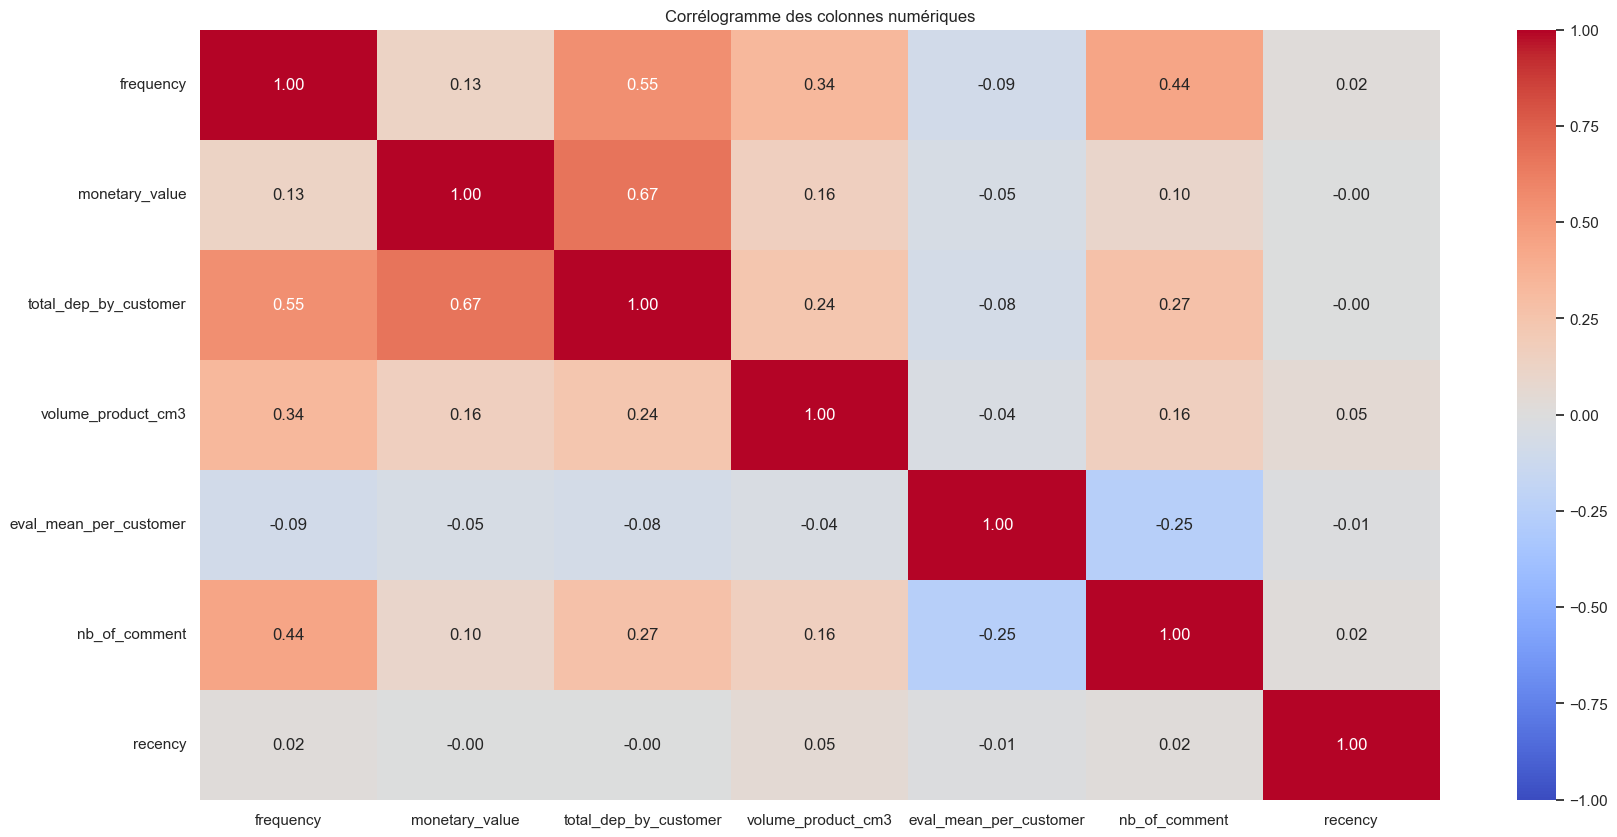

In [104]:
show_correlogram(rfm_total)

In [105]:
rfm_total.dtypes

customer_unique_id                object
period                            object
last_order                datetime64[ns]
frequency                          int64
monetary_value                   float64
total_dep_by_customer            float64
volume_product_cm3               float64
fav_categ                         object
eval_mean_per_customer           float64
nb_of_comment                    float64
fav_payment_type                  object
satisfaction_client               object
recency                            int64
dtype: object